# Imports and datasets creation

In [ ]:
import csv
import torch 
import sklearn
import scipy
from scipy import io
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from torch.autograd import Variable
import torchvision
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt
from torchvision import datasets
import torch.utils.data as data
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from sklearn.datasets import make_moons, make_blobs, make_circles
from tqdm.notebook import trange, tqdm
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from scipy.optimize import linear_sum_assignment as linear_assignment
from typing import Optional
import seaborn as sns

import copy
import random
import time
from math import floor

import os


In [ ]:
cuda = True if torch.cuda.is_available() else False
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)

float_Tensor = torch.FloatTensor
if cuda: float_Tensor = torch.cuda.FloatTensor
	
drop_last = True
shuffle = False

In [ ]:
def get_squeezed_gauss_np():
	# Do not normilize!
	data, labels = make_blobs(n_samples=1000, centers=[(0.45, 0.5), (0.55, 0.5)], cluster_std=((0.005, 0.15), (0.005, 0.15)))
	data = data.astype("float")
	labels = labels.astype("int")
	return data, labels

def get_squeezed_gauss_dataloader(batch_size=100):
	data, labels = get_squeezed_gauss_np()

	# Convert to tensor dataset
	data = torch.Tensor(data)
	data_shape = data.shape[1]
	labels = torch.Tensor(labels)
	final_dataset = TensorDataset(data, labels)
	dataloader = DataLoader(final_dataset, batch_size=batch_size, drop_last=drop_last, shuffle=shuffle)

	return dataloader, data_shape

In [ ]:
squeezed_dataloader, squeezed_data_shape = get_squeezed_gauss_dataloader(batch_size=100)
squeezed_datapoints, squeezed_labels = get_squeezed_gauss_np()

In [ ]:
def get_rings_np():
	data, labels = make_circles(n_samples=1000, factor=0.3, noise=0.05, random_state=0)
	scaler = MinMaxScaler()
	data = scaler.fit_transform(data)
	data = data.astype("float")
	labels = labels.astype("int")
	return data, labels

def get_rings_dataloader(batch_size=64):
	data, labels = get_rings_np()

	# Convert to tensor dataset
	data = torch.Tensor(data)
	data_shape = data.shape[1]
	labels = torch.Tensor(labels)
	final_dataset = TensorDataset(data, labels)
	dataloader = DataLoader(final_dataset, batch_size=batch_size, drop_last=drop_last, shuffle=shuffle)

	return dataloader, data_shape

In [ ]:
rings_dataloader, rings_data_shape = get_rings_dataloader(batch_size=64)
rings_datapoints, rings_labels = get_rings_np()

In [ ]:
def get_moons_np():
	data, labels = make_moons(n_samples=1_000, noise=0.05, random_state=0)
	scaler = MinMaxScaler()
	data = scaler.fit_transform(data)
	data = data.astype("float")
	labels = labels.astype("int")
	return data, labels

def get_moons_dataloader(batch_size=64):
	data, labels = get_moons_np()

	# Convert to tensor dataset
	data = torch.Tensor(data)
	data_shape = data.shape[1]
	labels = torch.Tensor(labels)
	final_dataset = TensorDataset(data, labels)
	dataloader = DataLoader(final_dataset, batch_size=batch_size, drop_last=drop_last, shuffle=shuffle)

	return dataloader, data_shape

In [ ]:
moons_dataloader, moons_data_shape = get_moons_dataloader(batch_size=64)
moons_datapoints, moons_labels = get_moons_np()

# Autoencoder/Custom dataset/function declarations

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, datapoints, labels, transform=None):

    self.datapoints = datapoints
    self.labels = labels
    self.transform = transform

  def __getitem__(self, index):
    sample = self.datapoints[index], self.labels[index]

    if self.transform:
      sample = self.transform(sample)

    return sample
  
  def __len__(self):
    return len(self.datapoints)

In [ ]:
# TODO: search hungarian algorithm
def cluster_accuracy(y_true, y_predicted, cluster_number: Optional[int] = None):
	"""
	Calculate clustering accuracy after using the linear_sum_assignment function in SciPy to
	determine reassignments.

	:param y_true: list of true cluster numbers, an integer array 0-indexed
	:param y_predicted: list of predicted cluster numbers, an integer array 0-indexed
	:param cluster_number: number of clusters, if None then calculated from input
	:return: reassignment dictionary, clustering accuracy
	"""
	if cluster_number is None:
		# assume labels are 0-indexed
		cluster_number = (max(y_predicted.max(), y_true.max()) + 1)
	count_matrix = np.zeros((cluster_number, cluster_number), dtype=np.int64)
	for i in range(y_predicted.size):
		count_matrix[y_predicted[i], y_true[i]] += 1

	row_ind, col_ind = linear_assignment(count_matrix.max() - count_matrix)
	reassignment = dict(zip(row_ind, col_ind))
	accuracy = count_matrix[row_ind, col_ind].sum() / y_predicted.size
	return reassignment, accuracy

def transform_clusters_to_labels(clusters, labels):
	# Find the cluster ids (labels)
	c_ids = np.unique(clusters)

	# Dictionary to transform cluster label to real label
	dict_clusters_to_labels = dict()

	# For every cluster find the most frequent data label
	for c_id in c_ids:
		indexes_of_cluster_i = np.where(c_id == clusters)
		elements, frequency = np.unique(labels[indexes_of_cluster_i], return_counts=True)
		true_label_index = np.argmax(frequency)
		true_label = elements[true_label_index]
		dict_clusters_to_labels[c_id] = true_label

	# Change the cluster labels to real labels
	for i, element in enumerate(clusters):
		clusters[i] = dict_clusters_to_labels[element]

	return clusters



In [ ]:
def check_number_of_representatives(Y): # TODO: check for empty clusters
  cluster_map = {}

  for element in Y:
    if element not in cluster_map:
      cluster_map[element] = 1
    else:
      cluster_map[element] += 1

  for cluster_number in cluster_map.keys():
    print("Cluster", cluster_number, ":", cluster_map[cluster_number], "elements \n")

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dimension, hl1_neurons, hl2_neurons, latent_dimension):
        super().__init__()

        # Encoder Model
        self.input_dimension = input_dimension
        self.hl1_neurons = hl1_neurons
        self.hl2_neurons = hl2_neurons
        self.latent_dimension = latent_dimension

        self.encoder_model = nn.Sequential(
          nn.Linear(input_dimension, self.hl1_neurons),
          nn.Sigmoid(),
          nn.BatchNorm1d(self.hl1_neurons),
          nn.Linear(self.hl1_neurons, self.hl2_neurons),
          nn.Sigmoid(),
          nn.BatchNorm1d(self.hl2_neurons),
        )
        
        # Latent Space
        self.latent_space = nn.Sequential(
          nn.Linear(self.hl2_neurons, self.latent_dimension),
          nn.Sigmoid(),
          nn.BatchNorm1d(self.latent_dimension),
        )

        # Decoder Model
        self.decoder_model = nn.Sequential(
          nn.Linear(self.latent_dimension, self.hl2_neurons),
          nn.Sigmoid(),
          nn.BatchNorm1d(self.hl2_neurons),
          nn.Linear(self.hl2_neurons, self.hl1_neurons),
          nn.BatchNorm1d(self.hl1_neurons),
          nn.Linear(self.hl1_neurons, input_dimension),
          nn.Sigmoid(),
        )

    def forward(self, x):
      x = self.encoder_model(x)
      x = self.latent_space(x)
      x = self.decoder_model(x)
      return x
  
    def encoder(self, x, device):
      x = torch.from_numpy(x).to(device)
      x= x.float()
      x = self.encoder_model(x)
      x = self.latent_space(x)
      return x.cpu().detach().numpy()

In [ ]:
def train_autoencoder(device, dataloader, autoencoder, epochs=500):
	criterion = nn.MSELoss().to(device)
	optimizer = optim.Adam(autoencoder.parameters(), lr=1e-4, weight_decay=1e-5)
	loss_list = list()
	batch_size = 64
	
	autoencoder.train()
	for epoch in range(epochs):
		loss = 0
		for batch_index, (batch, labels) in enumerate(dataloader):
			# Data to the GPU (cuda)
			batch = Variable(batch.type(float_Tensor))
			
			# Indexes
			low_index = batch_index * batch_size
			high_index = (batch_index + 1) * batch_size
			
			# reset the gradients to zero
			optimizer.zero_grad()
			autoencoder.zero_grad()

			# compute reconstructions
			reconstructions = autoencoder(batch)

			# compute training reconstruction loss
			train_loss = criterion(reconstructions, batch)

			# compute accumulated gradients
			train_loss.backward()

			# perform parameter update based on current gradients
			optimizer.step()

			# add the mini-batch training loss to epoch loss
			loss += train_loss.item()

		loss = loss / len(dataloader)
		loss_list.append(loss)
		print("Epoch: {}/{}, Loss: {:.6f}".format(epoch + 1, epochs, loss))
		
	autoencoder.eval()
	return autoencoder, loss_list

# Squeezed gauss clustering

In [ ]:
kmeans_2_clusters = KMeans(n_clusters=2, n_init=100).fit(squeezed_datapoints)
retrieved_labels_2_clusters = transform_clusters_to_labels(kmeans_2_clusters.labels_, squeezed_labels)

print("K_means greedy accuracy score for 2 clusters on initial space:",accuracy_score(squeezed_labels, retrieved_labels_2_clusters))
print("K_means hungarian accuracy score for 2 clusters on initial space:",cluster_accuracy(squeezed_labels, kmeans_2_clusters.labels_)[1])
print("K-means normalised mutual info score for 2 clusters on initial space:",normalized_mutual_info_score(squeezed_labels, kmeans_2_clusters.labels_))
print("K-means ARI for 2 clusters on initial space:",adjusted_rand_score(squeezed_labels, kmeans_2_clusters.labels_))
print("K-means silhouette score for 2 clusters on initial space:",silhouette_score(squeezed_datapoints, kmeans_2_clusters.labels_))

K_means greedy accuracy score for 2 clusters on initial space: 0.502
K_means hungarian accuracy score for 2 clusters on initial space: 0.502
K-means normalised mutual info score for 2 clusters on initial space: 1.1550642835735016e-05
K-means ARI for 2 clusters on initial space: -0.0009854102529095134
K-means silhouette score for 2 clusters on initial space: 0.4777476758301503


In [ ]:
aggloClustering_2_clusters = AgglomerativeClustering(n_clusters=2).fit(squeezed_datapoints)
agglo_retrieved_labels = transform_clusters_to_labels(aggloClustering_2_clusters.labels_, squeezed_labels)

# print the stats on agglomerative clustering

print("Agglomerative clustering on initial space greedy accuracy score:",accuracy_score(squeezed_labels, agglo_retrieved_labels))
print("Agglomerative clustering on initial space hungarian accuracy score:",cluster_accuracy(squeezed_labels, aggloClustering_2_clusters.labels_)[1])
print("Normalised mutual info score on agglomerative clustering on initial space:",normalized_mutual_info_score(squeezed_labels, aggloClustering_2_clusters.labels_))
print("Agglomerative clustering ARI on initial space:",adjusted_rand_score(squeezed_labels, aggloClustering_2_clusters.labels_))
print("Agglomerative clustering silhouette score for 10 clusters on initial space:",silhouette_score(squeezed_datapoints, aggloClustering_2_clusters.labels_))

Agglomerative clustering on initial space greedy accuracy score: 0.549
Agglomerative clustering on initial space hungarian accuracy score: 0.549
Normalised mutual info score on agglomerative clustering on initial space: 0.00710264785398796
Agglomerative clustering ARI on initial space: 0.008628406993909623
Agglomerative clustering silhouette score for 10 clusters on initial space: 0.468668367731435


In [ ]:
data_TSNE = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=400, learning_rate='auto').fit_transform(squeezed_datapoints)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.008037


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.673233
[t-SNE] KL divergence after 400 iterations: 0.346179


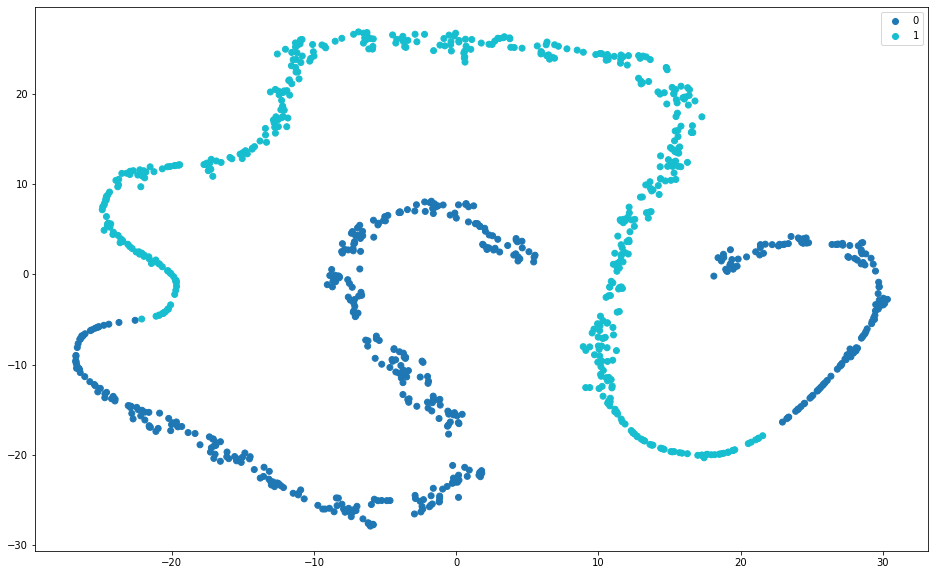

In [ ]:
dataset_labels = [0,1]

plt.figure(figsize=(16,10))
scatterplot = plt.scatter(
    x=data_TSNE[:,0], y=data_TSNE[:,1],
    c=squeezed_labels,
    cmap="tab10"
)

handles, _ = scatterplot.legend_elements(prop='colors')
plt.legend(handles, dataset_labels)

In [ ]:
def run_experiment(K, dataloader, data_shape, datapoints, labels, epochs=30, hl1_neurons=700, hl2_neurons=200, latent_dimension=10):

  print('Experiment results for k-means with k =', K, 'clusters:\n')
  print('Running k-means algorithm in order to get our pseudolabels: \n')

  kmeans_initial = KMeans(n_clusters=K, n_init=100).fit(datapoints) 
  cluster_centers = kmeans_initial.cluster_centers_
  cluster_labels = kmeans_initial.labels_
  real_labels = transform_clusters_to_labels(cluster_labels, labels)

  # check TSNE representation of our features according to the k categories

  # print("Creating TSNE representation of our features according to the k categories...\n")

  # pseudolabels_indices = [i for i in range(K)]

  # plt.figure(figsize=(16,10)) 
  # kmeans_scatterplot = plt.scatter(
  #     x=data_TSNE[:,0], y=data_TSNE[:,1],
  #     c=cluster_labels,
  #     cmap="gist_rainbow"
  # )

  # handles = kmeans_scatterplot.legend_elements(num=pseudolabels_indices)[0]
  # plt.legend(handles, pseudolabels_indices)

  # savestring = 'pseudolabels_TSNE_initial_space_k=' + str(K) + '.png'
  # plt.savefig(savestring)

  # find out accuracy of the algorithm in the initial space

  kmeans_initial_hungarian_acc = cluster_accuracy(labels, cluster_labels)[1]
  kmeans_initial_NMI = normalized_mutual_info_score(labels, cluster_labels)
  kmeans_initial_ARI = adjusted_rand_score(labels, cluster_labels)

  print("K_means greedy accuracy score (initial space):",accuracy_score(labels, real_labels))
  print("K_means hungarian accuracy score (initial space):",kmeans_initial_hungarian_acc)
  print("Normalised mutual info score (initial space):",kmeans_initial_NMI)
  print("ARI (initial space):",kmeans_initial_ARI, "\n")

  # using the autoencoder model on our data

  print('Using the autoencoder model on our data: \n')

  kmeans_accuracy_scores = []
  k_means_silhouette_scores = []
  k_means_cluster_error_scores = []
  kmeans_NMI_scores = []
  kmeans_ARI_scores = []
  agglo_accuracy_scores = []
  agglo_NMI_scores = []
  agglo_ARI_scores = []
  agglo_silhouette_scores = []
  
  for i in range(10):

    print("ROUND NUMBER ",i + 1,":\n")
    autoencoder = Autoencoder(input_dimension=data_shape, hl1_neurons=hl1_neurons, hl2_neurons=hl2_neurons, latent_dimension=latent_dimension).to(device)
    autoencoder, loss_list = train_autoencoder(device, dataloader, autoencoder, epochs=epochs)
    latent_data = autoencoder.encoder(datapoints, device)

    # data_TSNE = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=400, learning_rate='auto').fit_transform(latent_data)

    # dataset_labels = [0,1,2,3,4,5,6,7,8,9]

    # plt.figure(figsize=(16,10))
    # scatterplot = plt.scatter(
    #     x=data_TSNE[:,0], y=data_TSNE[:,1],
    #     c=labels,
    #     cmap="tab10"
    # )

    # handles, _ = scatterplot.legend_elements(prop='colors')
    # plt.legend(handles, dataset_labels)
    
    print("Creating a k-means model on latent data:\n")

    # Maybe we need Standar Scaler

    # std_scaler = StandardScaler()
    # latent_data = std_scaler.fit_transform(latent_data)

    # Clustering on transformed space

    new_kmeans = KMeans(n_clusters=2, n_init=100).fit(latent_data)

    kmeans_clusters = new_kmeans.labels_
    kmeans_cluster_error = new_kmeans.inertia_
    k_means_cluster_error_scores.append(kmeans_cluster_error)
    kmeans_greedy_labels = transform_clusters_to_labels(kmeans_clusters, labels)

    # print the stats on the transformed space
    kmeans_greedy_acc = accuracy_score(labels, kmeans_greedy_labels)

    # These metrics as input they use the output of the clustering algorithm
    kmeans_hungarian_acc = cluster_accuracy(labels, kmeans_clusters)[1]
    kmeans_NMI = normalized_mutual_info_score(labels, kmeans_clusters)
    kmeans_ARI = adjusted_rand_score(labels, kmeans_clusters)

    kmeans_accuracy_scores.append(kmeans_hungarian_acc)
    kmeans_NMI_scores.append(kmeans_NMI)
    kmeans_ARI_scores.append(kmeans_ARI)

    k_means_silhouette_score = silhouette_score(latent_data, kmeans_clusters)
    k_means_silhouette_scores.append(k_means_silhouette_score)

    print("K-means with 8 clusters on latent space stats: \n")
    print("K-means on latent space greedy accuracy score:",kmeans_greedy_acc)
    print("K-means on latent space hungarian accuracy score:",kmeans_hungarian_acc)
    print("Normalised mutual info score on k-means on latent space:", kmeans_NMI)
    print("ARI score on k-means on latent space:", kmeans_ARI)
    print("K-means cluster error on latent space:", kmeans_cluster_error)
    print("K-means silhouette score on latent space:", k_means_silhouette_score, "\n")

    # do agglomerative clustering on the transformed space

    print("Doing agglomerative clustering on MLP output vectors:\n")
    aggloClustering = AgglomerativeClustering(n_clusters=2).fit(latent_data)
    aggloClustering_clusters = aggloClustering.labels_
    agglo_greedy_labels = transform_clusters_to_labels(aggloClustering_clusters, labels)

    # print the stats on agglomerative clustering
    agglo_greedy_acc = accuracy_score(labels, agglo_greedy_labels)
    agglo_hungarian_acc = cluster_accuracy(labels, aggloClustering_clusters)[1]
    agglo_NMI = normalized_mutual_info_score(labels, aggloClustering_clusters)
    agglo_ARI = adjusted_rand_score(labels, aggloClustering_clusters)
    agglo_silhouette = k_means_silhouette_score = silhouette_score(latent_data, aggloClustering_clusters)

    agglo_accuracy_scores.append(agglo_greedy_acc)
    agglo_NMI_scores.append(agglo_NMI)
    agglo_ARI_scores.append(agglo_ARI)
    agglo_silhouette_scores.append(agglo_silhouette)

    print("Agglomerative clustering on latent space greedy accuracy score:", agglo_greedy_acc)
    print("Agglomerative clustering on latent space hungarian accuracy score:", agglo_hungarian_acc)
    print("Normalised mutual info score on agglomerative clustering on latent space:",agglo_NMI, "\n")
    print("ARI score on agglomerative clustering on latent space:", agglo_ARI, "\n")

  print("Average k-means accuracy score at latent space:", sum(kmeans_accuracy_scores) / len(kmeans_accuracy_scores), "\n")
  print("Average k-means NMI score at latent space:", sum(kmeans_NMI_scores) / len(kmeans_NMI_scores), "\n")
  print("Average k-means ARI score at latent space:", sum(kmeans_ARI_scores) / len(kmeans_ARI_scores), "\n")
  print("Average agglomerative clustering accuracy score at latent space:", sum(agglo_accuracy_scores) / len(agglo_accuracy_scores), "\n")
  print("Average agglomerative clustering NMI score at latent space:", sum(agglo_NMI_scores) / len(agglo_NMI_scores), "\n")
  print("Average agglomerative clustering ARI score at latent space:", sum(agglo_ARI_scores) / len(agglo_ARI_scores), "\n")
  print("Average k-means silhouette score on latent space:", sum(k_means_silhouette_scores) / len(k_means_silhouette_scores), "\n")
  print("Average k-means cluster error on latent space:", sum(k_means_cluster_error_scores) / len(k_means_cluster_error_scores), "\n")

  return [ kmeans_accuracy_scores, kmeans_NMI_scores, kmeans_ARI_scores, agglo_accuracy_scores, agglo_NMI_scores, agglo_ARI_scores, k_means_silhouette_scores, agglo_silhouette_scores]

In [ ]:
res = run_experiment(20, squeezed_dataloader, squeezed_data_shape, squeezed_datapoints, squeezed_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 20 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.999
K_means hungarian accuracy score (initial space): 0.999
Normalised mutual info score (initial space): 0.9895915066199539
ARI (initial space): 0.995999996008016 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.006246
Epoch: 2/50, Loss: 0.002906
Epoch: 3/50, Loss: 0.002671
Epoch: 4/50, Loss: 0.002450
Epoch: 5/50, Loss: 0.002259
Epoch: 6/50, Loss: 0.002143
Epoch: 7/50, Loss: 0.002088
Epoch: 8/50, Loss: 0.002013
Epoch: 9/50, Loss: 0.001941
Epoch: 10/50, Loss: 0.001868
Epoch: 11/50, Loss: 0.001801
Epoch: 12/50, Loss: 0.001733
Epoch: 13/50, Loss: 0.001695
Epoch: 14/50, Loss: 0.001653
Epoch: 15/50, Loss: 0.001618
Epoch: 16/50, Loss: 0.001587
Epoch: 17/50, Loss: 0.001561
Epoch: 18/50, Loss: 0.001539
Epoch: 19/50, Loss: 0.001520
Epoch: 20/50, Loss: 0.001505
Epoch: 21/50, Loss: 0.001493
Epoch: 

In [ ]:
print(np.mean(res[7]))
print(np.std(res[7]))

0.58736527
0.098489136


In [ ]:
results_for_k_5 = run_experiment(5, squeezed_dataloader, squeezed_data_shape, squeezed_datapoints, squeezed_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 5 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.714
K_means hungarian accuracy score (initial space): 0.714
Normalised mutual info score (initial space): 0.13691168461564904
ARI (initial space): 0.1823671332036374 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.005621
Epoch: 2/50, Loss: 0.002243
Epoch: 3/50, Loss: 0.002044
Epoch: 4/50, Loss: 0.001987
Epoch: 5/50, Loss: 0.001857
Epoch: 6/50, Loss: 0.001766
Epoch: 7/50, Loss: 0.001692
Epoch: 8/50, Loss: 0.001648
Epoch: 9/50, Loss: 0.001610
Epoch: 10/50, Loss: 0.001590
Epoch: 11/50, Loss: 0.001573
Epoch: 12/50, Loss: 0.001560
Epoch: 13/50, Loss: 0.001551
Epoch: 14/50, Loss: 0.001544
Epoch: 15/50, Loss: 0.001538
Epoch: 16/50, Loss: 0.001534
Epoch: 17/50, Loss: 0.001530
Epoch: 18/50, Loss: 0.001527
Epoch: 19/50, Loss: 0.001524
Epoch: 20/50, Loss: 0.001523
Epoch: 21/50, Loss: 0.001520
Epoch:

In [ ]:
results_for_k_10 = run_experiment(10, squeezed_dataloader, squeezed_data_shape, squeezed_datapoints, squeezed_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 10 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.939
K_means hungarian accuracy score (initial space): 0.939
Normalised mutual info score (initial space): 0.6766927291906428
ARI (initial space): 0.7706550949596624 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.020403
Epoch: 2/50, Loss: 0.007929
Epoch: 3/50, Loss: 0.004220
Epoch: 4/50, Loss: 0.003655
Epoch: 5/50, Loss: 0.003491
Epoch: 6/50, Loss: 0.003277
Epoch: 7/50, Loss: 0.003102
Epoch: 8/50, Loss: 0.002995
Epoch: 9/50, Loss: 0.003041
Epoch: 10/50, Loss: 0.002922
Epoch: 11/50, Loss: 0.002957
Epoch: 12/50, Loss: 0.002962
Epoch: 13/50, Loss: 0.002707
Epoch: 14/50, Loss: 0.003116
Epoch: 15/50, Loss: 0.002906
Epoch: 16/50, Loss: 0.002909
Epoch: 17/50, Loss: 0.003037
Epoch: 18/50, Loss: 0.002925
Epoch: 19/50, Loss: 0.003123
Epoch: 20/50, Loss: 0.002903
Epoch: 21/50, Loss: 0.002807
Epoch:

In [ ]:
results_for_k_15 = run_experiment(15, squeezed_dataloader, squeezed_data_shape, squeezed_datapoints, squeezed_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 15 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.988
K_means hungarian accuracy score (initial space): 0.988
Normalised mutual info score (initial space): 0.9181024446799153
ARI (initial space): 0.9525285083602998 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.003697
Epoch: 2/50, Loss: 0.001993
Epoch: 3/50, Loss: 0.001836
Epoch: 4/50, Loss: 0.001719
Epoch: 5/50, Loss: 0.001625
Epoch: 6/50, Loss: 0.001567
Epoch: 7/50, Loss: 0.001544
Epoch: 8/50, Loss: 0.001529
Epoch: 9/50, Loss: 0.001522
Epoch: 10/50, Loss: 0.001520
Epoch: 11/50, Loss: 0.001519
Epoch: 12/50, Loss: 0.001520
Epoch: 13/50, Loss: 0.001518
Epoch: 14/50, Loss: 0.001514
Epoch: 15/50, Loss: 0.001512
Epoch: 16/50, Loss: 0.001513
Epoch: 17/50, Loss: 0.001518
Epoch: 18/50, Loss: 0.001547
Epoch: 19/50, Loss: 0.001636
Epoch: 20/50, Loss: 0.001543
Epoch: 21/50, Loss: 0.001539
Epoch:

In [ ]:
results_for_k_20 = run_experiment(20, squeezed_dataloader, squeezed_data_shape, squeezed_datapoints, squeezed_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 20 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.997
K_means hungarian accuracy score (initial space): 0.997
Normalised mutual info score (initial space): 0.970780299319961
ARI (initial space): 0.988024012072048 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.005197
Epoch: 2/50, Loss: 0.002704
Epoch: 3/50, Loss: 0.002382
Epoch: 4/50, Loss: 0.002211
Epoch: 5/50, Loss: 0.002091
Epoch: 6/50, Loss: 0.001995
Epoch: 7/50, Loss: 0.001996
Epoch: 8/50, Loss: 0.001879
Epoch: 9/50, Loss: 0.001873
Epoch: 10/50, Loss: 0.001794
Epoch: 11/50, Loss: 0.001710
Epoch: 12/50, Loss: 0.001681
Epoch: 13/50, Loss: 0.001654
Epoch: 14/50, Loss: 0.001623
Epoch: 15/50, Loss: 0.001606
Epoch: 16/50, Loss: 0.001592
Epoch: 17/50, Loss: 0.001580
Epoch: 18/50, Loss: 0.001567
Epoch: 19/50, Loss: 0.001555
Epoch: 20/50, Loss: 0.001548
Epoch: 21/50, Loss: 0.001540
Epoch: 2

In [ ]:
results_for_k_25 = run_experiment(25, squeezed_dataloader, squeezed_data_shape, squeezed_datapoints, squeezed_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 25 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.999
K_means hungarian accuracy score (initial space): 0.999
Normalised mutual info score (initial space): 0.9895915066199539
ARI (initial space): 0.995999996008016 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.009593
Epoch: 2/50, Loss: 0.002637
Epoch: 3/50, Loss: 0.002250
Epoch: 4/50, Loss: 0.002227
Epoch: 5/50, Loss: 0.002142
Epoch: 6/50, Loss: 0.001981
Epoch: 7/50, Loss: 0.001912
Epoch: 8/50, Loss: 0.001845
Epoch: 9/50, Loss: 0.001801
Epoch: 10/50, Loss: 0.001753
Epoch: 11/50, Loss: 0.001714
Epoch: 12/50, Loss: 0.001685
Epoch: 13/50, Loss: 0.001660
Epoch: 14/50, Loss: 0.001638
Epoch: 15/50, Loss: 0.001620
Epoch: 16/50, Loss: 0.001604
Epoch: 17/50, Loss: 0.001591
Epoch: 18/50, Loss: 0.001577
Epoch: 19/50, Loss: 0.001565
Epoch: 20/50, Loss: 0.001554
Epoch: 21/50, Loss: 0.001545
Epoch: 

In [ ]:
results_for_k_30 = run_experiment(30, squeezed_dataloader, squeezed_data_shape, squeezed_datapoints, squeezed_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 30 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.009239
Epoch: 2/50, Loss: 0.002403
Epoch: 3/50, Loss: 0.002151
Epoch: 4/50, Loss: 0.001966
Epoch: 5/50, Loss: 0.001879
Epoch: 6/50, Loss: 0.001760
Epoch: 7/50, Loss: 0.001693
Epoch: 8/50, Loss: 0.001655
Epoch: 9/50, Loss: 0.001625
Epoch: 10/50, Loss: 0.001599
Epoch: 11/50, Loss: 0.001585
Epoch: 12/50, Loss: 0.001571
Epoch: 13/50, Loss: 0.001560
Epoch: 14/50, Loss: 0.001550
Epoch: 15/50, Loss: 0.001543
Epoch: 16/50, Loss: 0.001536
Epoch: 17/50, Loss: 0.001531
Epoch: 18/50, Loss: 0.001526
Epoch: 19/50, Loss: 0.001522
Epoch: 20/50, Loss: 0.001519
Epoch: 21/50, Loss: 0.001516
Epoch: 22/50, Loss: 0.001512
Epoch: 23/5

In [ ]:
results_for_k_35 = run_experiment(35, squeezed_dataloader, squeezed_data_shape, squeezed_datapoints, squeezed_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 35 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.006807
Epoch: 2/50, Loss: 0.001969
Epoch: 3/50, Loss: 0.001620
Epoch: 4/50, Loss: 0.001604
Epoch: 5/50, Loss: 0.001549
Epoch: 6/50, Loss: 0.001515
Epoch: 7/50, Loss: 0.001516
Epoch: 8/50, Loss: 0.001501
Epoch: 9/50, Loss: 0.001493
Epoch: 10/50, Loss: 0.001498
Epoch: 11/50, Loss: 0.001504
Epoch: 12/50, Loss: 0.001493
Epoch: 13/50, Loss: 0.001488
Epoch: 14/50, Loss: 0.001493
Epoch: 15/50, Loss: 0.001495
Epoch: 16/50, Loss: 0.001496
Epoch: 17/50, Loss: 0.001524
Epoch: 18/50, Loss: 0.001568
Epoch: 19/50, Loss: 0.001572
Epoch: 20/50, Loss: 0.001532
Epoch: 21/50, Loss: 0.001511
Epoch: 22/50, Loss: 0.001503
Epoch: 23/5

In [ ]:
results_for_k_40 = run_experiment(40, squeezed_dataloader, squeezed_data_shape, squeezed_datapoints, squeezed_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 40 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.015217
Epoch: 2/50, Loss: 0.009466
Epoch: 3/50, Loss: 0.005474
Epoch: 4/50, Loss: 0.003982
Epoch: 5/50, Loss: 0.003671
Epoch: 6/50, Loss: 0.003285
Epoch: 7/50, Loss: 0.003334
Epoch: 8/50, Loss: 0.003301
Epoch: 9/50, Loss: 0.003159
Epoch: 10/50, Loss: 0.003253
Epoch: 11/50, Loss: 0.003156
Epoch: 12/50, Loss: 0.003093
Epoch: 13/50, Loss: 0.002898
Epoch: 14/50, Loss: 0.002842
Epoch: 15/50, Loss: 0.002972
Epoch: 16/50, Loss: 0.003017
Epoch: 17/50, Loss: 0.003010
Epoch: 18/50, Loss: 0.002917
Epoch: 19/50, Loss: 0.003017
Epoch: 20/50, Loss: 0.002787
Epoch: 21/50, Loss: 0.002950
Epoch: 22/50, Loss: 0.002945
Epoch: 23/5

In [ ]:
results_for_k_45 = run_experiment(45, squeezed_dataloader, squeezed_data_shape, squeezed_datapoints, squeezed_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 45 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.006732
Epoch: 2/50, Loss: 0.002193
Epoch: 3/50, Loss: 0.002163
Epoch: 4/50, Loss: 0.002101
Epoch: 5/50, Loss: 0.001898
Epoch: 6/50, Loss: 0.001801
Epoch: 7/50, Loss: 0.001745
Epoch: 8/50, Loss: 0.001694
Epoch: 9/50, Loss: 0.001661
Epoch: 10/50, Loss: 0.001638
Epoch: 11/50, Loss: 0.001622
Epoch: 12/50, Loss: 0.001605
Epoch: 13/50, Loss: 0.001593
Epoch: 14/50, Loss: 0.001583
Epoch: 15/50, Loss: 0.001575
Epoch: 16/50, Loss: 0.001568
Epoch: 17/50, Loss: 0.001561
Epoch: 18/50, Loss: 0.001556
Epoch: 19/50, Loss: 0.001551
Epoch: 20/50, Loss: 0.001546
Epoch: 21/50, Loss: 0.001537
Epoch: 22/50, Loss: 0.001530
Epoch: 23/5

In [ ]:
results_for_k_50 = run_experiment(50, squeezed_dataloader, squeezed_data_shape, squeezed_datapoints, squeezed_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 50 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.006208
Epoch: 2/50, Loss: 0.002567
Epoch: 3/50, Loss: 0.002105
Epoch: 4/50, Loss: 0.001864
Epoch: 5/50, Loss: 0.001742
Epoch: 6/50, Loss: 0.001670
Epoch: 7/50, Loss: 0.001606
Epoch: 8/50, Loss: 0.001569
Epoch: 9/50, Loss: 0.001551
Epoch: 10/50, Loss: 0.001533
Epoch: 11/50, Loss: 0.001528
Epoch: 12/50, Loss: 0.001522
Epoch: 13/50, Loss: 0.001517
Epoch: 14/50, Loss: 0.001516
Epoch: 15/50, Loss: 0.001525
Epoch: 16/50, Loss: 0.001522
Epoch: 17/50, Loss: 0.001521
Epoch: 18/50, Loss: 0.001522
Epoch: 19/50, Loss: 0.001515
Epoch: 20/50, Loss: 0.001514
Epoch: 21/50, Loss: 0.001532
Epoch: 22/50, Loss: 0.001535
Epoch: 23/5

In [ ]:
results_for_k_55 = run_experiment(55, squeezed_dataloader, squeezed_data_shape, squeezed_datapoints, squeezed_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 55 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.017912
Epoch: 2/50, Loss: 0.006106
Epoch: 3/50, Loss: 0.004064
Epoch: 4/50, Loss: 0.003963
Epoch: 5/50, Loss: 0.003886
Epoch: 6/50, Loss: 0.003406
Epoch: 7/50, Loss: 0.003143
Epoch: 8/50, Loss: 0.003251
Epoch: 9/50, Loss: 0.003016
Epoch: 10/50, Loss: 0.003231
Epoch: 11/50, Loss: 0.003478
Epoch: 12/50, Loss: 0.003179
Epoch: 13/50, Loss: 0.003168
Epoch: 14/50, Loss: 0.003002
Epoch: 15/50, Loss: 0.003162
Epoch: 16/50, Loss: 0.003109
Epoch: 17/50, Loss: 0.003037
Epoch: 18/50, Loss: 0.002946
Epoch: 19/50, Loss: 0.003038
Epoch: 20/50, Loss: 0.002869
Epoch: 21/50, Loss: 0.002782
Epoch: 22/50, Loss: 0.002807
Epoch: 23/5

In [ ]:
results_for_k_60 = run_experiment(60, squeezed_dataloader, squeezed_data_shape, squeezed_datapoints, squeezed_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 60 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.007798
Epoch: 2/50, Loss: 0.002609
Epoch: 3/50, Loss: 0.002328
Epoch: 4/50, Loss: 0.002245
Epoch: 5/50, Loss: 0.002090
Epoch: 6/50, Loss: 0.001959
Epoch: 7/50, Loss: 0.001887
Epoch: 8/50, Loss: 0.001809
Epoch: 9/50, Loss: 0.001750
Epoch: 10/50, Loss: 0.001714
Epoch: 11/50, Loss: 0.001671
Epoch: 12/50, Loss: 0.001618
Epoch: 13/50, Loss: 0.001587
Epoch: 14/50, Loss: 0.001559
Epoch: 15/50, Loss: 0.001547
Epoch: 16/50, Loss: 0.001542
Epoch: 17/50, Loss: 0.001533
Epoch: 18/50, Loss: 0.001528
Epoch: 19/50, Loss: 0.001524
Epoch: 20/50, Loss: 0.001520
Epoch: 21/50, Loss: 0.001520
Epoch: 22/50, Loss: 0.001519
Epoch: 23/5

In [ ]:
kmeans_acc = np.zeros((5,12))
kmeans_NMI = np.zeros((5,12))
kmeans_ARI = np.zeros((5,12))
agglo_acc = np.zeros((5,12))
agglo_NMI = np.zeros((5,12))
agglo_ARI = np.zeros((5,12))
kmeans_silhouette = np.zeros((5,12))

for i in range(5):
  
  kmeans_acc[i][0] = results_for_k_5[0][i]
  kmeans_acc[i][1] = results_for_k_10[0][i]
  kmeans_acc[i][2] = results_for_k_15[0][i]
  kmeans_acc[i][3] = results_for_k_20[0][i]
  kmeans_acc[i][4] = results_for_k_25[0][i]
  kmeans_acc[i][5] = results_for_k_30[0][i]
  kmeans_acc[i][6] = results_for_k_35[0][i]
  kmeans_acc[i][7] = results_for_k_40[0][i]
  kmeans_acc[i][8] = results_for_k_45[0][i]
  kmeans_acc[i][9] = results_for_k_50[0][i]
  kmeans_acc[i][10] = results_for_k_55[0][i]
  kmeans_acc[i][11] = results_for_k_60[0][i]

  kmeans_NMI[i][0] = results_for_k_5[1][i]
  kmeans_NMI[i][1] = results_for_k_10[1][i]
  kmeans_NMI[i][2] = results_for_k_15[1][i]
  kmeans_NMI[i][3] = results_for_k_20[1][i]
  kmeans_NMI[i][4] = results_for_k_25[1][i]
  kmeans_NMI[i][5] = results_for_k_30[1][i]
  kmeans_NMI[i][6] = results_for_k_35[1][i]
  kmeans_NMI[i][7] = results_for_k_40[1][i]
  kmeans_NMI[i][8] = results_for_k_45[1][i]
  kmeans_NMI[i][9] = results_for_k_50[1][i]
  kmeans_NMI[i][10] = results_for_k_55[1][i]
  kmeans_NMI[i][11] = results_for_k_60[1][i]

  kmeans_ARI[i][0] = results_for_k_5[2][i]
  kmeans_ARI[i][1] = results_for_k_10[2][i]
  kmeans_ARI[i][2] = results_for_k_15[2][i]
  kmeans_ARI[i][3] = results_for_k_20[2][i]
  kmeans_ARI[i][4] = results_for_k_25[2][i]
  kmeans_ARI[i][5] = results_for_k_30[2][i]
  kmeans_ARI[i][6] = results_for_k_35[2][i]
  kmeans_ARI[i][7] = results_for_k_40[2][i]
  kmeans_ARI[i][8] = results_for_k_45[2][i]
  kmeans_ARI[i][9] = results_for_k_50[2][i]
  kmeans_ARI[i][10] = results_for_k_55[2][i]
  kmeans_ARI[i][11] = results_for_k_60[2][i]

  agglo_acc[i][0] = results_for_k_5[3][i]
  agglo_acc[i][1] = results_for_k_10[3][i]
  agglo_acc[i][2] = results_for_k_15[3][i]
  agglo_acc[i][3] = results_for_k_20[3][i]
  agglo_acc[i][4] = results_for_k_25[3][i]
  agglo_acc[i][5] = results_for_k_30[3][i]
  agglo_acc[i][6] = results_for_k_35[3][i]
  agglo_acc[i][7] = results_for_k_40[3][i]
  agglo_acc[i][8] = results_for_k_45[3][i]
  agglo_acc[i][9] = results_for_k_50[3][i]
  agglo_acc[i][10] = results_for_k_55[3][i]
  agglo_acc[i][11] = results_for_k_60[3][i]

  agglo_NMI[i][0] = results_for_k_5[4][i]
  agglo_NMI[i][1] = results_for_k_10[4][i]
  agglo_NMI[i][2] = results_for_k_15[4][i]
  agglo_NMI[i][3] = results_for_k_20[4][i]
  agglo_NMI[i][4] = results_for_k_25[4][i]
  agglo_NMI[i][5] = results_for_k_30[4][i]
  agglo_NMI[i][6] = results_for_k_35[4][i]
  agglo_NMI[i][7] = results_for_k_40[4][i]
  agglo_NMI[i][8] = results_for_k_45[4][i]
  agglo_NMI[i][9] = results_for_k_50[4][i]
  agglo_NMI[i][10] = results_for_k_55[4][i]
  agglo_NMI[i][11] = results_for_k_60[4][i]

  agglo_ARI[i][0] = results_for_k_5[5][i]
  agglo_ARI[i][1] = results_for_k_10[5][i]
  agglo_ARI[i][2] = results_for_k_15[5][i]
  agglo_ARI[i][3] = results_for_k_20[5][i]
  agglo_ARI[i][4] = results_for_k_25[5][i]
  agglo_ARI[i][5] = results_for_k_30[5][i]
  agglo_ARI[i][6] = results_for_k_35[5][i]
  agglo_ARI[i][7] = results_for_k_40[5][i]
  agglo_ARI[i][8] = results_for_k_45[5][i]
  agglo_ARI[i][9] = results_for_k_50[5][i]
  agglo_ARI[i][10] = results_for_k_55[5][i]
  agglo_ARI[i][11] = results_for_k_60[5][i]

  kmeans_silhouette[i][0] = results_for_k_5[6][i]
  kmeans_silhouette[i][1] = results_for_k_10[6][i]
  kmeans_silhouette[i][2] = results_for_k_15[6][i]
  kmeans_silhouette[i][3] = results_for_k_20[6][i]
  kmeans_silhouette[i][4] = results_for_k_25[6][i]
  kmeans_silhouette[i][5] = results_for_k_30[6][i]
  kmeans_silhouette[i][6] = results_for_k_35[6][i]
  kmeans_silhouette[i][7] = results_for_k_40[6][i]
  kmeans_silhouette[i][8] = results_for_k_45[6][i]
  kmeans_silhouette[i][9] = results_for_k_50[6][i]
  kmeans_silhouette[i][10] = results_for_k_55[6][i]
  kmeans_silhouette[i][11] = results_for_k_60[6][i]


Text(0.5, 0, 'K')

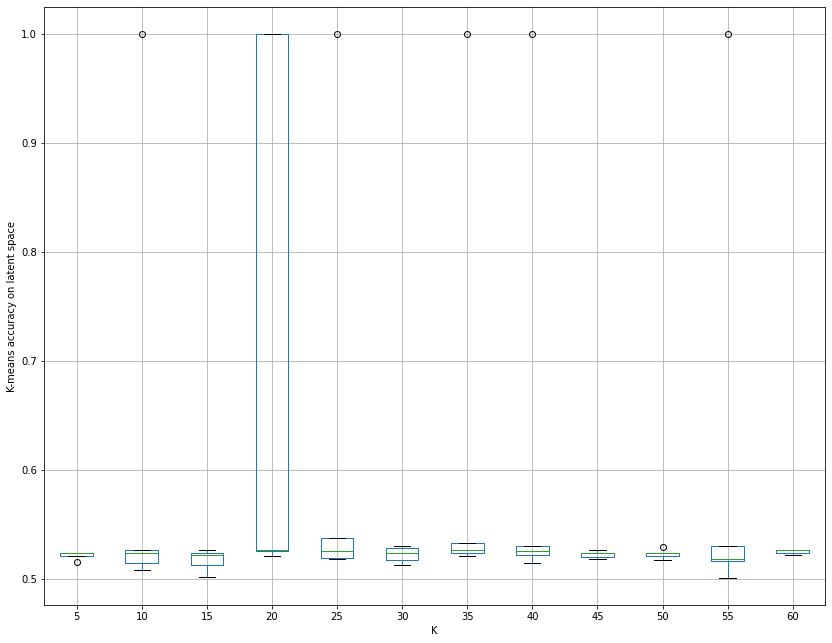

In [ ]:
columns = ['5', '10','15', '20', '25', '30', '35', '40', '45', '50', '55', '60']

df = pd.DataFrame(kmeans_acc,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means accuracy on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

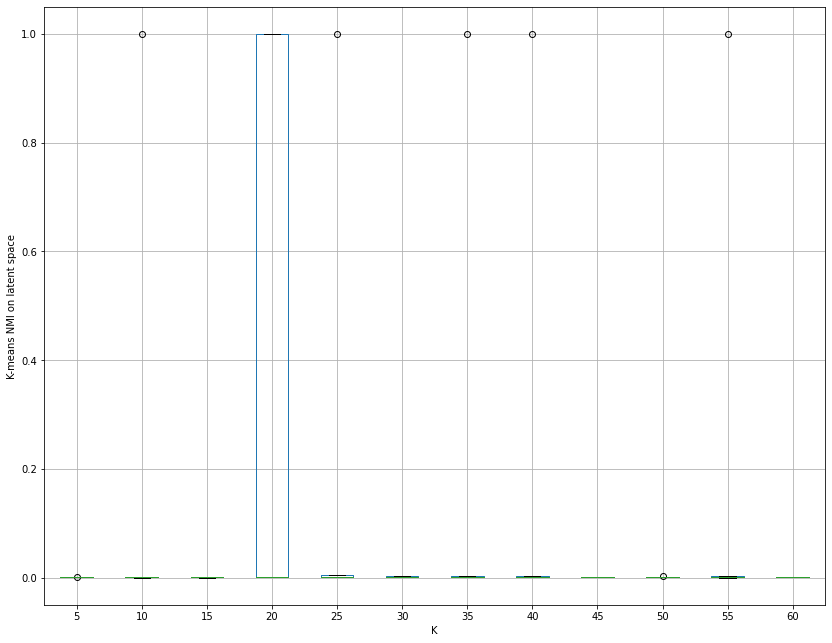

In [ ]:
df = pd.DataFrame(kmeans_NMI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means NMI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

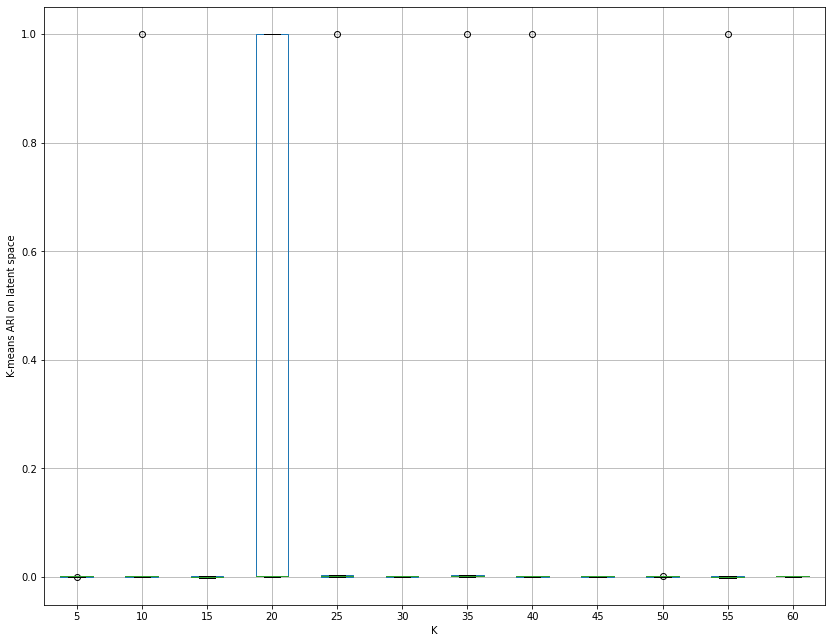

In [ ]:
df = pd.DataFrame(kmeans_ARI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means ARI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

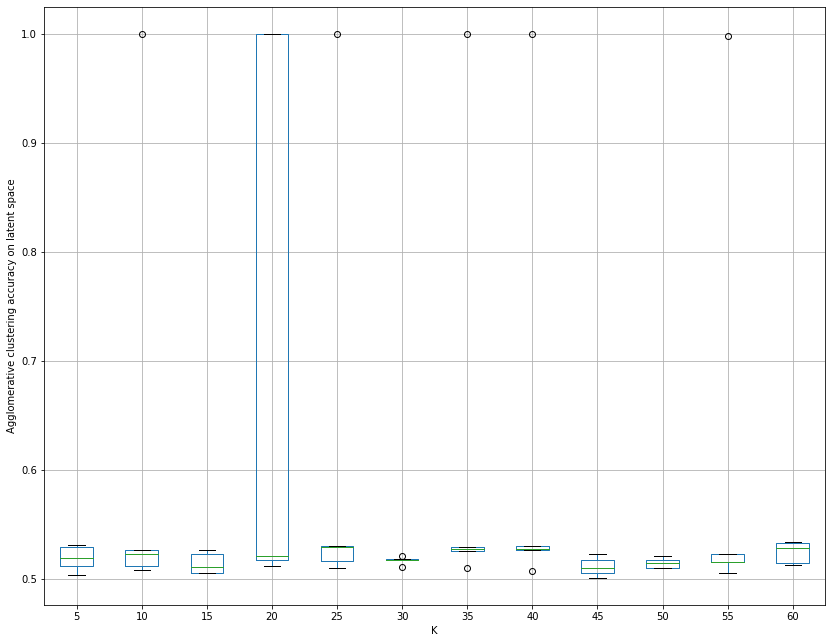

In [ ]:
df = pd.DataFrame(agglo_acc,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering accuracy on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

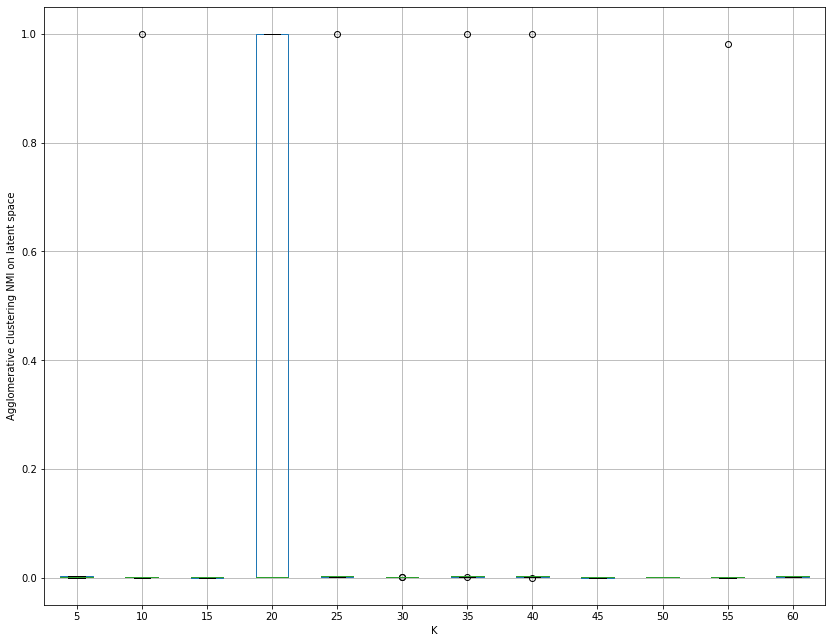

In [ ]:
df = pd.DataFrame(agglo_NMI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering NMI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

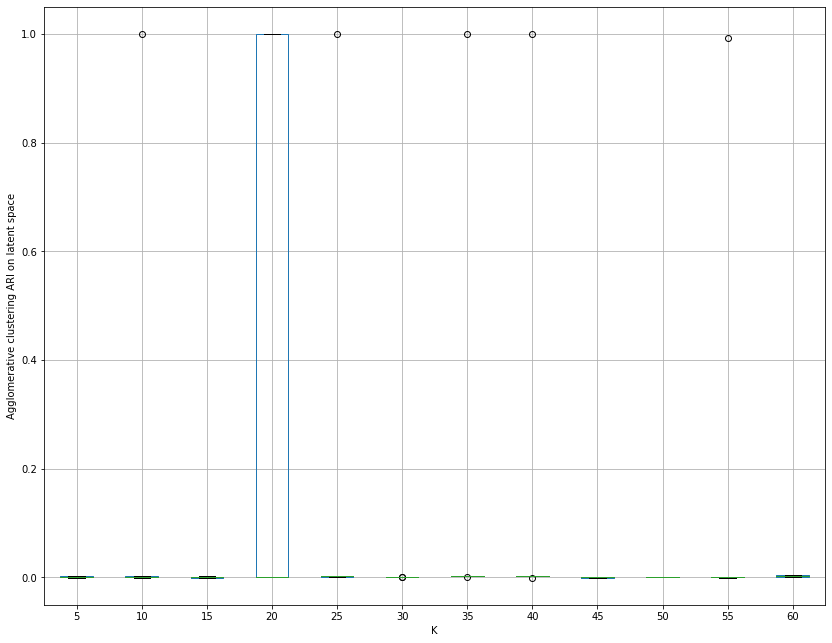

In [ ]:
df = pd.DataFrame(agglo_ARI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering ARI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

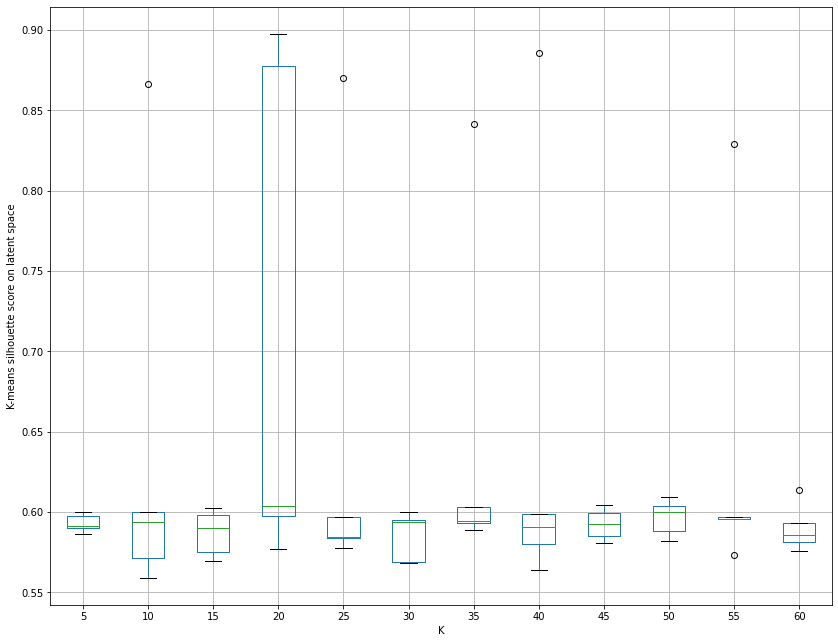

In [ ]:
df = pd.DataFrame(kmeans_silhouette,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means silhouette score on latent space')
boxplot.set_xlabel('K')

# Rings clustering

In [ ]:
kmeans_2_clusters = KMeans(n_clusters=2, n_init=100).fit(rings_datapoints)
retrieved_labels_2_clusters = transform_clusters_to_labels(kmeans_2_clusters.labels_, rings_labels)

print("K_means greedy accuracy score for 2 clusters on initial space:",accuracy_score(rings_labels, retrieved_labels_2_clusters))
print("K_means hungarian accuracy score for 2 clusters on initial space:",cluster_accuracy(rings_labels, kmeans_2_clusters.labels_)[1])
print("K-means normalised mutual info score for 2 clusters on initial space:",normalized_mutual_info_score(rings_labels, kmeans_2_clusters.labels_))
print("K-means ARI for 2 clusters on initial space:",adjusted_rand_score(rings_labels, kmeans_2_clusters.labels_))
print("K-means silhouette score for 2 clusters on initial space:",silhouette_score(rings_datapoints, kmeans_2_clusters.labels_))

K_means greedy accuracy score for 2 clusters on initial space: 0.503
K_means hungarian accuracy score for 2 clusters on initial space: 0.503
K-means normalised mutual info score for 2 clusters on initial space: 2.5969938683868158e-05
K-means ARI for 2 clusters on initial space: -0.0009659318288842226
K-means silhouette score for 2 clusters on initial space: 0.3028383731758318


In [ ]:
aggloClustering_2_clusters = AgglomerativeClustering(n_clusters=2).fit(rings_datapoints)
agglo_retrieved_labels = transform_clusters_to_labels(aggloClustering_2_clusters.labels_, rings_labels)

# print the stats on agglomerative clustering

print("Agglomerative clustering on initial space greedy accuracy score:",accuracy_score(rings_labels, agglo_retrieved_labels))
print("Agglomerative clustering on initial space hungarian accuracy score:",cluster_accuracy(rings_labels, aggloClustering_2_clusters.labels_)[1])
print("Normalised mutual info score on agglomerative clustering on initial space:",normalized_mutual_info_score(rings_labels, aggloClustering_2_clusters.labels_))
print("Agglomerative clustering ARI on initial space:",adjusted_rand_score(rings_labels, aggloClustering_2_clusters.labels_))
print("Agglomerative clustering silhouette score for 10 clusters on initial space:",silhouette_score(rings_datapoints, aggloClustering_2_clusters.labels_))

Agglomerative clustering on initial space greedy accuracy score: 0.713
Agglomerative clustering on initial space hungarian accuracy score: 0.713
Normalised mutual info score on agglomerative clustering on initial space: 0.2920222303745548
Agglomerative clustering ARI on initial space: 0.18092624162887083
Agglomerative clustering silhouette score for 10 clusters on initial space: 0.363527922566883


In [ ]:
data_TSNE = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=400, learning_rate='auto').fit_transform(rings_datapoints)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.024617


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.012081
[t-SNE] KL divergence after 400 iterations: 0.390851


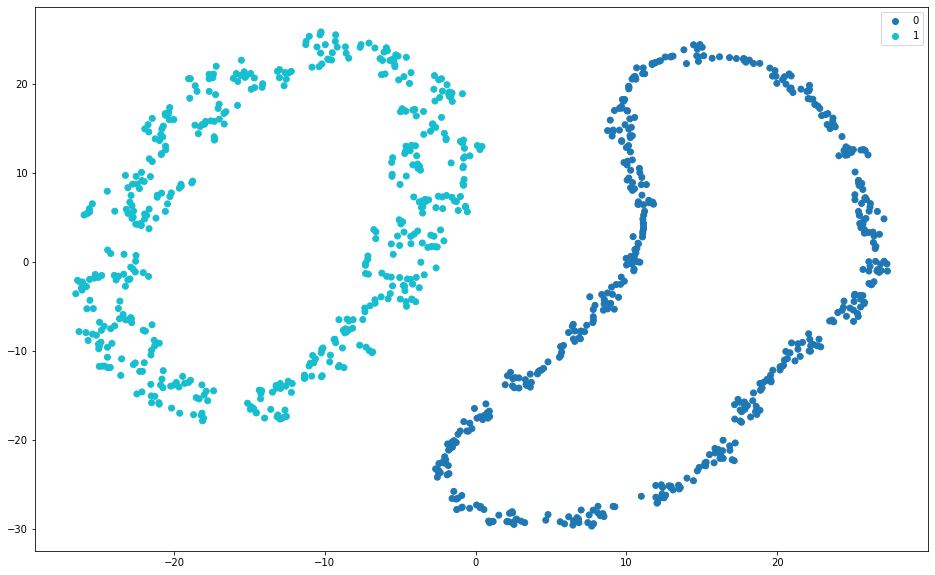

In [ ]:
dataset_labels = [0,1]

plt.figure(figsize=(16,10))
scatterplot = plt.scatter(
    x=data_TSNE[:,0], y=data_TSNE[:,1],
    c=rings_labels,
    cmap="tab10"
)

handles, _ = scatterplot.legend_elements(prop='colors')
plt.legend(handles, dataset_labels)

In [ ]:
def run_experiment(K, dataloader, data_shape, datapoints, labels, epochs=30, hl1_neurons=700, hl2_neurons=200, latent_dimension=10):

  print('Experiment results for k-means with k =', K, 'clusters:\n')
  print('Running k-means algorithm in order to get our pseudolabels: \n')

  kmeans_initial = KMeans(n_clusters=K, n_init=100).fit(datapoints) 
  cluster_centers = kmeans_initial.cluster_centers_
  cluster_labels = kmeans_initial.labels_
  real_labels = transform_clusters_to_labels(cluster_labels, labels)

  # check TSNE representation of our features according to the k categories

  # print("Creating TSNE representation of our features according to the k categories...\n")

  # pseudolabels_indices = [i for i in range(K)]

  # plt.figure(figsize=(16,10)) 
  # kmeans_scatterplot = plt.scatter(
  #     x=data_TSNE[:,0], y=data_TSNE[:,1],
  #     c=cluster_labels,
  #     cmap="gist_rainbow"
  # )

  # handles = kmeans_scatterplot.legend_elements(num=pseudolabels_indices)[0]
  # plt.legend(handles, pseudolabels_indices)

  # savestring = 'pseudolabels_TSNE_initial_space_k=' + str(K) + '.png'
  # plt.savefig(savestring)

  # find out accuracy of the algorithm in the initial space

  kmeans_initial_hungarian_acc = cluster_accuracy(labels, cluster_labels)[1]
  kmeans_initial_NMI = normalized_mutual_info_score(labels, cluster_labels)
  kmeans_initial_ARI = adjusted_rand_score(labels, cluster_labels)

  print("K_means greedy accuracy score (initial space):",accuracy_score(labels, real_labels))
  print("K_means hungarian accuracy score (initial space):",kmeans_initial_hungarian_acc)
  print("Normalised mutual info score (initial space):",kmeans_initial_NMI)
  print("ARI (initial space):",kmeans_initial_ARI, "\n")

  # using the autoencoder model on our data

  print('Using the autoencoder model on our data: \n')

  kmeans_accuracy_scores = []
  k_means_silhouette_scores = []
  k_means_cluster_error_scores = []
  kmeans_NMI_scores = []
  kmeans_ARI_scores = []
  agglo_accuracy_scores = []
  agglo_NMI_scores = []
  agglo_ARI_scores = []
  agglo_silhouette_scores = []
  
  for i in range(10):

    print("ROUND NUMBER ",i + 1,":\n")
    autoencoder = Autoencoder(input_dimension=data_shape, hl1_neurons=hl1_neurons, hl2_neurons=hl2_neurons, latent_dimension=latent_dimension).to(device)
    autoencoder, loss_list = train_autoencoder(device, dataloader, autoencoder, epochs=epochs)
    latent_data = autoencoder.encoder(datapoints, device)

    # data_TSNE = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=400, learning_rate='auto').fit_transform(latent_data)

    # dataset_labels = [0,1,2,3,4,5,6,7,8,9]

    # plt.figure(figsize=(16,10))
    # scatterplot = plt.scatter(
    #     x=data_TSNE[:,0], y=data_TSNE[:,1],
    #     c=labels,
    #     cmap="tab10"
    # )

    # handles, _ = scatterplot.legend_elements(prop='colors')
    # plt.legend(handles, dataset_labels)
    
    print("Creating a k-means model on latent data:\n")

    # Maybe we need Standar Scaler

    # std_scaler = StandardScaler()
    # latent_data = std_scaler.fit_transform(latent_data)

    # Clustering on transformed space

    new_kmeans = KMeans(n_clusters=2, n_init=100).fit(latent_data)

    kmeans_clusters = new_kmeans.labels_
    kmeans_cluster_error = new_kmeans.inertia_
    k_means_cluster_error_scores.append(kmeans_cluster_error)
    kmeans_greedy_labels = transform_clusters_to_labels(kmeans_clusters, labels)

    # print the stats on the transformed space
    kmeans_greedy_acc = accuracy_score(labels, kmeans_greedy_labels)

    # These metrics as input they use the output of the clustering algorithm
    kmeans_hungarian_acc = cluster_accuracy(labels, kmeans_clusters)[1]
    kmeans_NMI = normalized_mutual_info_score(labels, kmeans_clusters)
    kmeans_ARI = adjusted_rand_score(labels, kmeans_clusters)

    kmeans_accuracy_scores.append(kmeans_hungarian_acc)
    kmeans_NMI_scores.append(kmeans_NMI)
    kmeans_ARI_scores.append(kmeans_ARI)

    k_means_silhouette_score = silhouette_score(latent_data, kmeans_clusters)
    k_means_silhouette_scores.append(k_means_silhouette_score)

    print("K-means with 8 clusters on latent space stats: \n")
    print("K-means on latent space greedy accuracy score:",kmeans_greedy_acc)
    print("K-means on latent space hungarian accuracy score:",kmeans_hungarian_acc)
    print("Normalised mutual info score on k-means on latent space:", kmeans_NMI)
    print("ARI score on k-means on latent space:", kmeans_ARI)
    print("K-means cluster error on latent space:", kmeans_cluster_error)
    print("K-means silhouette score on latent space:", k_means_silhouette_score, "\n")

    # do agglomerative clustering on the transformed space

    print("Doing agglomerative clustering on MLP output vectors:\n")
    aggloClustering = AgglomerativeClustering(n_clusters=2).fit(latent_data)
    aggloClustering_clusters = aggloClustering.labels_
    agglo_greedy_labels = transform_clusters_to_labels(aggloClustering_clusters, labels)

    # print the stats on agglomerative clustering
    agglo_greedy_acc = accuracy_score(labels, agglo_greedy_labels)
    agglo_hungarian_acc = cluster_accuracy(labels, aggloClustering_clusters)[1]
    agglo_NMI = normalized_mutual_info_score(labels, aggloClustering_clusters)
    agglo_ARI = adjusted_rand_score(labels, aggloClustering_clusters)
    agglo_silhouette = k_means_silhouette_score = silhouette_score(latent_data, aggloClustering_clusters)

    agglo_accuracy_scores.append(agglo_greedy_acc)
    agglo_NMI_scores.append(agglo_NMI)
    agglo_ARI_scores.append(agglo_ARI)
    agglo_silhouette_scores.append(agglo_silhouette)

    print("Agglomerative clustering on latent space greedy accuracy score:", agglo_greedy_acc)
    print("Agglomerative clustering on latent space hungarian accuracy score:", agglo_hungarian_acc)
    print("Normalised mutual info score on agglomerative clustering on latent space:",agglo_NMI, "\n")
    print("ARI score on agglomerative clustering on latent space:", agglo_ARI, "\n")

  print("Average k-means accuracy score at latent space:", sum(kmeans_accuracy_scores) / len(kmeans_accuracy_scores), "\n")
  print("Average k-means NMI score at latent space:", sum(kmeans_NMI_scores) / len(kmeans_NMI_scores), "\n")
  print("Average k-means ARI score at latent space:", sum(kmeans_ARI_scores) / len(kmeans_ARI_scores), "\n")
  print("Average agglomerative clustering accuracy score at latent space:", sum(agglo_accuracy_scores) / len(agglo_accuracy_scores), "\n")
  print("Average agglomerative clustering NMI score at latent space:", sum(agglo_NMI_scores) / len(agglo_NMI_scores), "\n")
  print("Average agglomerative clustering ARI score at latent space:", sum(agglo_ARI_scores) / len(agglo_ARI_scores), "\n")
  print("Average k-means silhouette score on latent space:", sum(k_means_silhouette_scores) / len(k_means_silhouette_scores), "\n")
  print("Average k-means cluster error on latent space:", sum(k_means_cluster_error_scores) / len(k_means_cluster_error_scores), "\n")

  return [ kmeans_accuracy_scores, kmeans_NMI_scores, kmeans_ARI_scores, agglo_accuracy_scores, agglo_NMI_scores, agglo_ARI_scores, k_means_silhouette_scores, agglo_silhouette_scores]

In [ ]:
res = run_experiment(50, rings_dataloader, rings_data_shape, rings_datapoints, rings_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 50 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.038477
Epoch: 2/50, Loss: 0.031945
Epoch: 3/50, Loss: 0.031526
Epoch: 4/50, Loss: 0.031044
Epoch: 5/50, Loss: 0.030626
Epoch: 6/50, Loss: 0.030162
Epoch: 7/50, Loss: 0.029753
Epoch: 8/50, Loss: 0.029405
Epoch: 9/50, Loss: 0.028817
Epoch: 10/50, Loss: 0.028454
Epoch: 11/50, Loss: 0.028408
Epoch: 12/50, Loss: 0.026052
Epoch: 13/50, Loss: 0.025569
Epoch: 14/50, Loss: 0.024649
Epoch: 15/50, Loss: 0.023888
Epoch: 16/50, Loss: 0.023419
Epoch: 17/50, Loss: 0.023211
Epoch: 18/50, Loss: 0.022479
Epoch: 19/50, Loss: 0.022037
Epoch: 20/50, Loss: 0.021586
Epoch: 21/50, Loss: 0.021157
Epoch: 22/50, Loss: 0.021093
Epoch: 23/5

In [ ]:
print(np.mean(res[7]))
print(np.std(res[7]))

0.5944311
0.012589742


In [ ]:
results_for_k_5 = run_experiment(5, rings_dataloader, rings_data_shape, rings_datapoints, rings_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 5 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.037469
Epoch: 2/50, Loss: 0.030277
Epoch: 3/50, Loss: 0.029590
Epoch: 4/50, Loss: 0.029014
Epoch: 5/50, Loss: 0.028253
Epoch: 6/50, Loss: 0.026682
Epoch: 7/50, Loss: 0.026671
Epoch: 8/50, Loss: 0.025032
Epoch: 9/50, Loss: 0.024617
Epoch: 10/50, Loss: 0.024164
Epoch: 11/50, Loss: 0.023623
Epoch: 12/50, Loss: 0.023223
Epoch: 13/50, Loss: 0.023113
Epoch: 14/50, Loss: 0.022057
Epoch: 15/50, Loss: 0.021521
Epoch: 16/50, Loss: 0.021376
Epoch: 17/50, Loss: 0.020848
Epoch: 18/50, Loss: 0.020505
Epoch: 19/50, Loss: 0.020143
Epoch: 20/50, Loss: 0.019827
Epoch: 21/50, Loss: 0.019551
Epoch: 22/50, Loss: 0.019307
Epoch: 23/50

In [ ]:
results_for_k_10 = run_experiment(10, rings_dataloader, rings_data_shape, rings_datapoints, rings_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 10 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.033251
Epoch: 2/50, Loss: 0.029513
Epoch: 3/50, Loss: 0.028968
Epoch: 4/50, Loss: 0.028734
Epoch: 5/50, Loss: 0.028491
Epoch: 6/50, Loss: 0.027409
Epoch: 7/50, Loss: 0.027741
Epoch: 8/50, Loss: 0.025903
Epoch: 9/50, Loss: 0.026200
Epoch: 10/50, Loss: 0.024953
Epoch: 11/50, Loss: 0.024040
Epoch: 12/50, Loss: 0.023522
Epoch: 13/50, Loss: 0.023235
Epoch: 14/50, Loss: 0.022430
Epoch: 15/50, Loss: 0.022385
Epoch: 16/50, Loss: 0.022350
Epoch: 17/50, Loss: 0.021920
Epoch: 18/50, Loss: 0.021320
Epoch: 19/50, Loss: 0.020835
Epoch: 20/50, Loss: 0.020609
Epoch: 21/50, Loss: 0.020386
Epoch: 22/50, Loss: 0.020343
Epoch: 23/5

In [ ]:
results_for_k_15 = run_experiment(15, rings_dataloader, rings_data_shape, rings_datapoints, rings_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 15 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.037109
Epoch: 2/50, Loss: 0.030547
Epoch: 3/50, Loss: 0.029650
Epoch: 4/50, Loss: 0.029027
Epoch: 5/50, Loss: 0.028165
Epoch: 6/50, Loss: 0.028591
Epoch: 7/50, Loss: 0.028211
Epoch: 8/50, Loss: 0.025773
Epoch: 9/50, Loss: 0.026010
Epoch: 10/50, Loss: 0.025361
Epoch: 11/50, Loss: 0.024826
Epoch: 12/50, Loss: 0.024039
Epoch: 13/50, Loss: 0.023504
Epoch: 14/50, Loss: 0.022802
Epoch: 15/50, Loss: 0.023012
Epoch: 16/50, Loss: 0.022499
Epoch: 17/50, Loss: 0.021896
Epoch: 18/50, Loss: 0.021459
Epoch: 19/50, Loss: 0.021495
Epoch: 20/50, Loss: 0.020887
Epoch: 21/50, Loss: 0.020456
Epoch: 22/50, Loss: 0.019912
Epoch: 23/5

In [ ]:
results_for_k_20 = run_experiment(20, rings_dataloader, rings_data_shape, rings_datapoints, rings_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 20 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.032390
Epoch: 2/50, Loss: 0.029611
Epoch: 3/50, Loss: 0.029136
Epoch: 4/50, Loss: 0.028181
Epoch: 5/50, Loss: 0.027438
Epoch: 6/50, Loss: 0.026464
Epoch: 7/50, Loss: 0.025909
Epoch: 8/50, Loss: 0.024824
Epoch: 9/50, Loss: 0.023811
Epoch: 10/50, Loss: 0.023675
Epoch: 11/50, Loss: 0.024161
Epoch: 12/50, Loss: 0.022736
Epoch: 13/50, Loss: 0.023733
Epoch: 14/50, Loss: 0.022320
Epoch: 15/50, Loss: 0.021867
Epoch: 16/50, Loss: 0.022391
Epoch: 17/50, Loss: 0.021863
Epoch: 18/50, Loss: 0.020889
Epoch: 19/50, Loss: 0.021307
Epoch: 20/50, Loss: 0.020956
Epoch: 21/50, Loss: 0.020685
Epoch: 22/50, Loss: 0.020565
Epoch: 23/5

In [ ]:
results_for_k_25 = run_experiment(25, rings_dataloader, rings_data_shape, rings_datapoints, rings_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 25 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.035557
Epoch: 2/50, Loss: 0.031473
Epoch: 3/50, Loss: 0.030815
Epoch: 4/50, Loss: 0.030033
Epoch: 5/50, Loss: 0.029652
Epoch: 6/50, Loss: 0.029185
Epoch: 7/50, Loss: 0.028753
Epoch: 8/50, Loss: 0.028037
Epoch: 9/50, Loss: 0.027145
Epoch: 10/50, Loss: 0.028031
Epoch: 11/50, Loss: 0.025322
Epoch: 12/50, Loss: 0.025779
Epoch: 13/50, Loss: 0.024971
Epoch: 14/50, Loss: 0.024683
Epoch: 15/50, Loss: 0.024001
Epoch: 16/50, Loss: 0.023864
Epoch: 17/50, Loss: 0.023077
Epoch: 18/50, Loss: 0.022831
Epoch: 19/50, Loss: 0.022258
Epoch: 20/50, Loss: 0.022353
Epoch: 21/50, Loss: 0.021231
Epoch: 22/50, Loss: 0.021264
Epoch: 23/5

In [ ]:
results_for_k_30 = run_experiment(30, rings_dataloader, rings_data_shape, rings_datapoints, rings_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 30 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.035128
Epoch: 2/50, Loss: 0.031059
Epoch: 3/50, Loss: 0.030183
Epoch: 4/50, Loss: 0.029500
Epoch: 5/50, Loss: 0.028811
Epoch: 6/50, Loss: 0.028533
Epoch: 7/50, Loss: 0.028431
Epoch: 8/50, Loss: 0.025925
Epoch: 9/50, Loss: 0.025822
Epoch: 10/50, Loss: 0.025044
Epoch: 11/50, Loss: 0.024966
Epoch: 12/50, Loss: 0.024426
Epoch: 13/50, Loss: 0.022929
Epoch: 14/50, Loss: 0.022454
Epoch: 15/50, Loss: 0.021829
Epoch: 16/50, Loss: 0.021390
Epoch: 17/50, Loss: 0.021007
Epoch: 18/50, Loss: 0.020697
Epoch: 19/50, Loss: 0.020477
Epoch: 20/50, Loss: 0.020074
Epoch: 21/50, Loss: 0.019815
Epoch: 22/50, Loss: 0.019444
Epoch: 23/5

In [ ]:
results_for_k_35 = run_experiment(35, rings_dataloader, rings_data_shape, rings_datapoints, rings_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 35 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.035091
Epoch: 2/50, Loss: 0.030621
Epoch: 3/50, Loss: 0.029941
Epoch: 4/50, Loss: 0.029504
Epoch: 5/50, Loss: 0.029280
Epoch: 6/50, Loss: 0.028927
Epoch: 7/50, Loss: 0.028627
Epoch: 8/50, Loss: 0.028293
Epoch: 9/50, Loss: 0.027216
Epoch: 10/50, Loss: 0.026746
Epoch: 11/50, Loss: 0.026762
Epoch: 12/50, Loss: 0.025252
Epoch: 13/50, Loss: 0.025051
Epoch: 14/50, Loss: 0.024144
Epoch: 15/50, Loss: 0.023707
Epoch: 16/50, Loss: 0.023505
Epoch: 17/50, Loss: 0.023696
Epoch: 18/50, Loss: 0.024155
Epoch: 19/50, Loss: 0.023045
Epoch: 20/50, Loss: 0.023648
Epoch: 21/50, Loss: 0.023356
Epoch: 22/50, Loss: 0.022083
Epoch: 23/5

In [ ]:
results_for_k_40 = run_experiment(40, rings_dataloader, rings_data_shape, rings_datapoints, rings_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 40 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.035449
Epoch: 2/50, Loss: 0.030789
Epoch: 3/50, Loss: 0.030173
Epoch: 4/50, Loss: 0.030109
Epoch: 5/50, Loss: 0.029744
Epoch: 6/50, Loss: 0.029256
Epoch: 7/50, Loss: 0.028988
Epoch: 8/50, Loss: 0.028671
Epoch: 9/50, Loss: 0.028186
Epoch: 10/50, Loss: 0.027487
Epoch: 11/50, Loss: 0.026678
Epoch: 12/50, Loss: 0.025893
Epoch: 13/50, Loss: 0.026135
Epoch: 14/50, Loss: 0.025882
Epoch: 15/50, Loss: 0.024433
Epoch: 16/50, Loss: 0.024058
Epoch: 17/50, Loss: 0.023545
Epoch: 18/50, Loss: 0.022978
Epoch: 19/50, Loss: 0.022567
Epoch: 20/50, Loss: 0.022639
Epoch: 21/50, Loss: 0.022349
Epoch: 22/50, Loss: 0.022630
Epoch: 23/5

In [ ]:
results_for_k_45 = run_experiment(45, rings_dataloader, rings_data_shape, rings_datapoints, rings_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 45 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.033564
Epoch: 2/50, Loss: 0.030395
Epoch: 3/50, Loss: 0.029688
Epoch: 4/50, Loss: 0.029389
Epoch: 5/50, Loss: 0.028694
Epoch: 6/50, Loss: 0.027963
Epoch: 7/50, Loss: 0.028156
Epoch: 8/50, Loss: 0.028292
Epoch: 9/50, Loss: 0.026060
Epoch: 10/50, Loss: 0.024502
Epoch: 11/50, Loss: 0.024289
Epoch: 12/50, Loss: 0.023611
Epoch: 13/50, Loss: 0.023583
Epoch: 14/50, Loss: 0.022764
Epoch: 15/50, Loss: 0.023479
Epoch: 16/50, Loss: 0.022711
Epoch: 17/50, Loss: 0.022160
Epoch: 18/50, Loss: 0.021488
Epoch: 19/50, Loss: 0.021582
Epoch: 20/50, Loss: 0.021242
Epoch: 21/50, Loss: 0.020942
Epoch: 22/50, Loss: 0.020945
Epoch: 23/5

In [ ]:
results_for_k_50 = run_experiment(50, rings_dataloader, rings_data_shape, rings_datapoints, rings_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 50 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.032804
Epoch: 2/50, Loss: 0.029786
Epoch: 3/50, Loss: 0.029238
Epoch: 4/50, Loss: 0.028794
Epoch: 5/50, Loss: 0.028664
Epoch: 6/50, Loss: 0.028061
Epoch: 7/50, Loss: 0.027166
Epoch: 8/50, Loss: 0.026727
Epoch: 9/50, Loss: 0.025442
Epoch: 10/50, Loss: 0.024801
Epoch: 11/50, Loss: 0.024251
Epoch: 12/50, Loss: 0.023221
Epoch: 13/50, Loss: 0.022651
Epoch: 14/50, Loss: 0.022417
Epoch: 15/50, Loss: 0.022017
Epoch: 16/50, Loss: 0.021949
Epoch: 17/50, Loss: 0.021344
Epoch: 18/50, Loss: 0.021430
Epoch: 19/50, Loss: 0.021437
Epoch: 20/50, Loss: 0.021705
Epoch: 21/50, Loss: 0.021123
Epoch: 22/50, Loss: 0.020759
Epoch: 23/5

In [ ]:
results_for_k_55 = run_experiment(55, rings_dataloader, rings_data_shape, rings_datapoints, rings_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 55 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.037522
Epoch: 2/50, Loss: 0.030514
Epoch: 3/50, Loss: 0.029192
Epoch: 4/50, Loss: 0.028408
Epoch: 5/50, Loss: 0.027251
Epoch: 6/50, Loss: 0.026956
Epoch: 7/50, Loss: 0.025937
Epoch: 8/50, Loss: 0.025258
Epoch: 9/50, Loss: 0.026517
Epoch: 10/50, Loss: 0.025352
Epoch: 11/50, Loss: 0.024011
Epoch: 12/50, Loss: 0.024077
Epoch: 13/50, Loss: 0.024064
Epoch: 14/50, Loss: 0.022903
Epoch: 15/50, Loss: 0.022954
Epoch: 16/50, Loss: 0.022426
Epoch: 17/50, Loss: 0.022046
Epoch: 18/50, Loss: 0.022660
Epoch: 19/50, Loss: 0.021983
Epoch: 20/50, Loss: 0.021181
Epoch: 21/50, Loss: 0.020834
Epoch: 22/50, Loss: 0.020979
Epoch: 23/5

In [ ]:
results_for_k_60 = run_experiment(60, rings_dataloader, rings_data_shape, rings_datapoints, rings_labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=1)

Experiment results for k-means with k = 60 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.034548
Epoch: 2/50, Loss: 0.031000
Epoch: 3/50, Loss: 0.029987
Epoch: 4/50, Loss: 0.029487
Epoch: 5/50, Loss: 0.028914
Epoch: 6/50, Loss: 0.028543
Epoch: 7/50, Loss: 0.027995
Epoch: 8/50, Loss: 0.027245
Epoch: 9/50, Loss: 0.026009
Epoch: 10/50, Loss: 0.025424
Epoch: 11/50, Loss: 0.024623
Epoch: 12/50, Loss: 0.023875
Epoch: 13/50, Loss: 0.023334
Epoch: 14/50, Loss: 0.022887
Epoch: 15/50, Loss: 0.022404
Epoch: 16/50, Loss: 0.021729
Epoch: 17/50, Loss: 0.021128
Epoch: 18/50, Loss: 0.020652
Epoch: 19/50, Loss: 0.020145
Epoch: 20/50, Loss: 0.019918
Epoch: 21/50, Loss: 0.019609
Epoch: 22/50, Loss: 0.019390
Epoch: 23/5

In [ ]:
kmeans_acc = np.zeros((5,12))
kmeans_NMI = np.zeros((5,12))
kmeans_ARI = np.zeros((5,12))
agglo_acc = np.zeros((5,12))
agglo_NMI = np.zeros((5,12))
agglo_ARI = np.zeros((5,12))
kmeans_silhouette = np.zeros((5,12))

for i in range(5):
  
  kmeans_acc[i][0] = results_for_k_5[0][i]
  kmeans_acc[i][1] = results_for_k_10[0][i]
  kmeans_acc[i][2] = results_for_k_15[0][i]
  kmeans_acc[i][3] = results_for_k_20[0][i]
  kmeans_acc[i][4] = results_for_k_25[0][i]
  kmeans_acc[i][5] = results_for_k_30[0][i]
  kmeans_acc[i][6] = results_for_k_35[0][i]
  kmeans_acc[i][7] = results_for_k_40[0][i]
  kmeans_acc[i][8] = results_for_k_45[0][i]
  kmeans_acc[i][9] = results_for_k_50[0][i]
  kmeans_acc[i][10] = results_for_k_55[0][i]
  kmeans_acc[i][11] = results_for_k_60[0][i]

  kmeans_NMI[i][0] = results_for_k_5[1][i]
  kmeans_NMI[i][1] = results_for_k_10[1][i]
  kmeans_NMI[i][2] = results_for_k_15[1][i]
  kmeans_NMI[i][3] = results_for_k_20[1][i]
  kmeans_NMI[i][4] = results_for_k_25[1][i]
  kmeans_NMI[i][5] = results_for_k_30[1][i]
  kmeans_NMI[i][6] = results_for_k_35[1][i]
  kmeans_NMI[i][7] = results_for_k_40[1][i]
  kmeans_NMI[i][8] = results_for_k_45[1][i]
  kmeans_NMI[i][9] = results_for_k_50[1][i]
  kmeans_NMI[i][10] = results_for_k_55[1][i]
  kmeans_NMI[i][11] = results_for_k_60[1][i]

  kmeans_ARI[i][0] = results_for_k_5[2][i]
  kmeans_ARI[i][1] = results_for_k_10[2][i]
  kmeans_ARI[i][2] = results_for_k_15[2][i]
  kmeans_ARI[i][3] = results_for_k_20[2][i]
  kmeans_ARI[i][4] = results_for_k_25[2][i]
  kmeans_ARI[i][5] = results_for_k_30[2][i]
  kmeans_ARI[i][6] = results_for_k_35[2][i]
  kmeans_ARI[i][7] = results_for_k_40[2][i]
  kmeans_ARI[i][8] = results_for_k_45[2][i]
  kmeans_ARI[i][9] = results_for_k_50[2][i]
  kmeans_ARI[i][10] = results_for_k_55[2][i]
  kmeans_ARI[i][11] = results_for_k_60[2][i]

  agglo_acc[i][0] = results_for_k_5[3][i]
  agglo_acc[i][1] = results_for_k_10[3][i]
  agglo_acc[i][2] = results_for_k_15[3][i]
  agglo_acc[i][3] = results_for_k_20[3][i]
  agglo_acc[i][4] = results_for_k_25[3][i]
  agglo_acc[i][5] = results_for_k_30[3][i]
  agglo_acc[i][6] = results_for_k_35[3][i]
  agglo_acc[i][7] = results_for_k_40[3][i]
  agglo_acc[i][8] = results_for_k_45[3][i]
  agglo_acc[i][9] = results_for_k_50[3][i]
  agglo_acc[i][10] = results_for_k_55[3][i]
  agglo_acc[i][11] = results_for_k_60[3][i]

  agglo_NMI[i][0] = results_for_k_5[4][i]
  agglo_NMI[i][1] = results_for_k_10[4][i]
  agglo_NMI[i][2] = results_for_k_15[4][i]
  agglo_NMI[i][3] = results_for_k_20[4][i]
  agglo_NMI[i][4] = results_for_k_25[4][i]
  agglo_NMI[i][5] = results_for_k_30[4][i]
  agglo_NMI[i][6] = results_for_k_35[4][i]
  agglo_NMI[i][7] = results_for_k_40[4][i]
  agglo_NMI[i][8] = results_for_k_45[4][i]
  agglo_NMI[i][9] = results_for_k_50[4][i]
  agglo_NMI[i][10] = results_for_k_55[4][i]
  agglo_NMI[i][11] = results_for_k_60[4][i]

  agglo_ARI[i][0] = results_for_k_5[5][i]
  agglo_ARI[i][1] = results_for_k_10[5][i]
  agglo_ARI[i][2] = results_for_k_15[5][i]
  agglo_ARI[i][3] = results_for_k_20[5][i]
  agglo_ARI[i][4] = results_for_k_25[5][i]
  agglo_ARI[i][5] = results_for_k_30[5][i]
  agglo_ARI[i][6] = results_for_k_35[5][i]
  agglo_ARI[i][7] = results_for_k_40[5][i]
  agglo_ARI[i][8] = results_for_k_45[5][i]
  agglo_ARI[i][9] = results_for_k_50[5][i]
  agglo_ARI[i][10] = results_for_k_55[5][i]
  agglo_ARI[i][11] = results_for_k_60[5][i]

  kmeans_silhouette[i][0] = results_for_k_5[6][i]
  kmeans_silhouette[i][1] = results_for_k_10[6][i]
  kmeans_silhouette[i][2] = results_for_k_15[6][i]
  kmeans_silhouette[i][3] = results_for_k_20[6][i]
  kmeans_silhouette[i][4] = results_for_k_25[6][i]
  kmeans_silhouette[i][5] = results_for_k_30[6][i]
  kmeans_silhouette[i][6] = results_for_k_35[6][i]
  kmeans_silhouette[i][7] = results_for_k_40[6][i]
  kmeans_silhouette[i][8] = results_for_k_45[6][i]
  kmeans_silhouette[i][9] = results_for_k_50[6][i]
  kmeans_silhouette[i][10] = results_for_k_55[6][i]
  kmeans_silhouette[i][11] = results_for_k_60[6][i]


Text(0.5, 0, 'K')

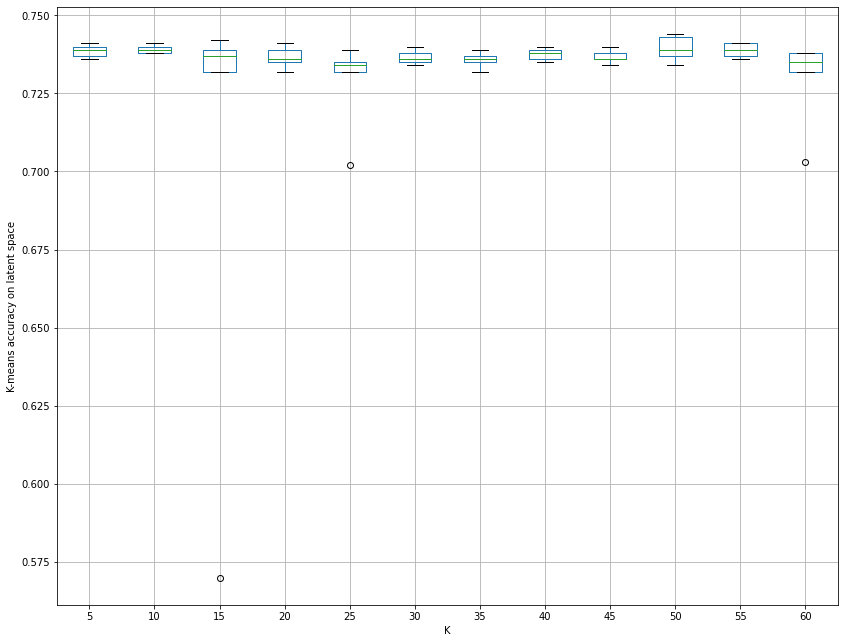

In [ ]:
columns = ['5', '10','15', '20', '25', '30', '35', '40', '45', '50', '55', '60']

df = pd.DataFrame(kmeans_acc,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means accuracy on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

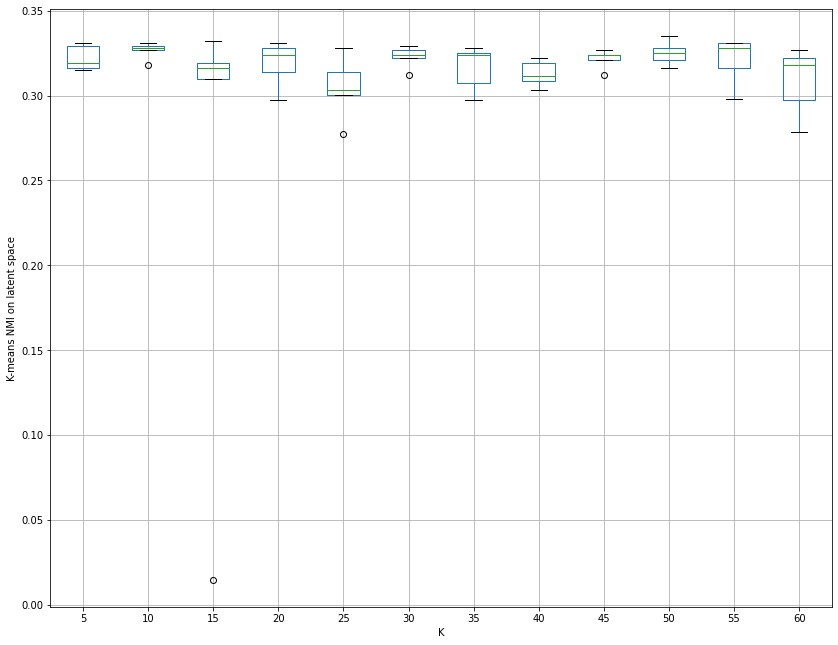

In [ ]:
df = pd.DataFrame(kmeans_NMI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means NMI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

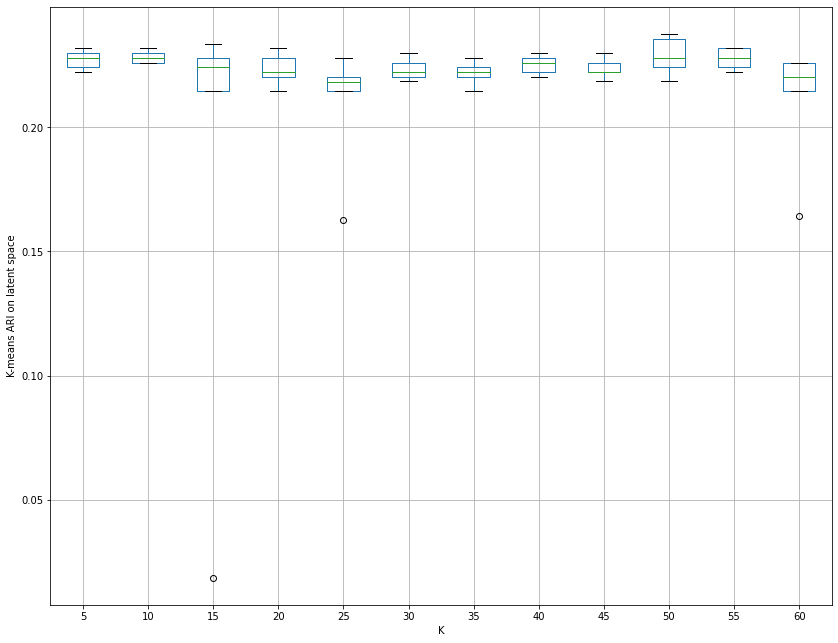

In [ ]:
df = pd.DataFrame(kmeans_ARI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means ARI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

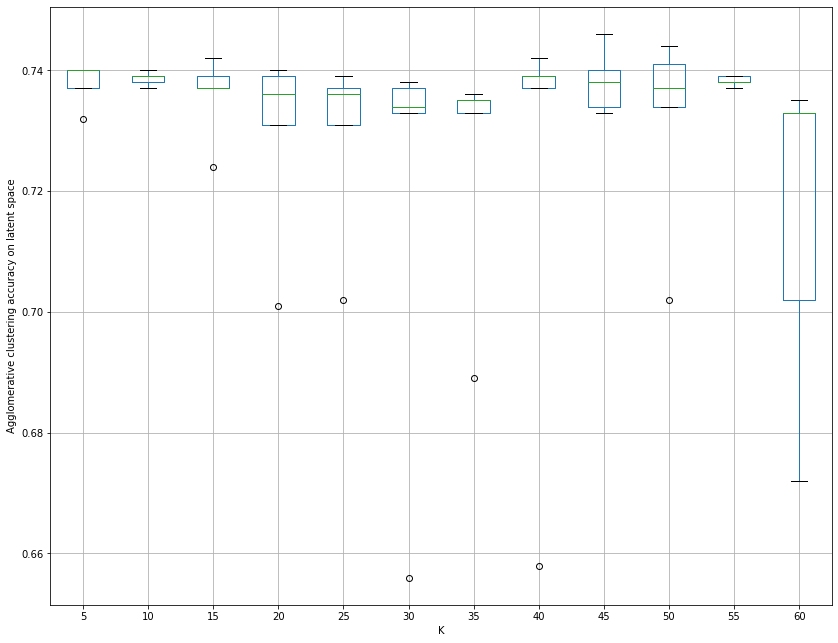

In [ ]:
df = pd.DataFrame(agglo_acc,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering accuracy on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

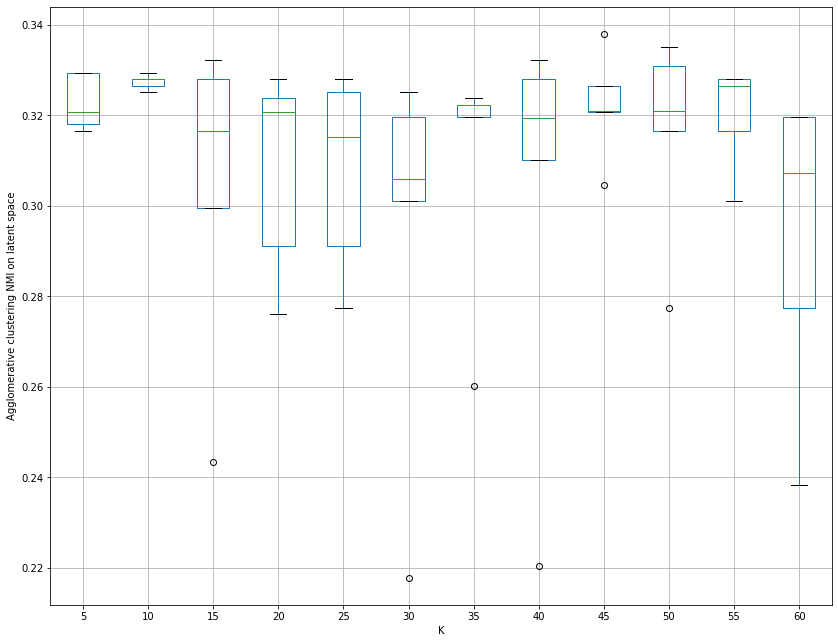

In [ ]:
df = pd.DataFrame(agglo_NMI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering NMI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

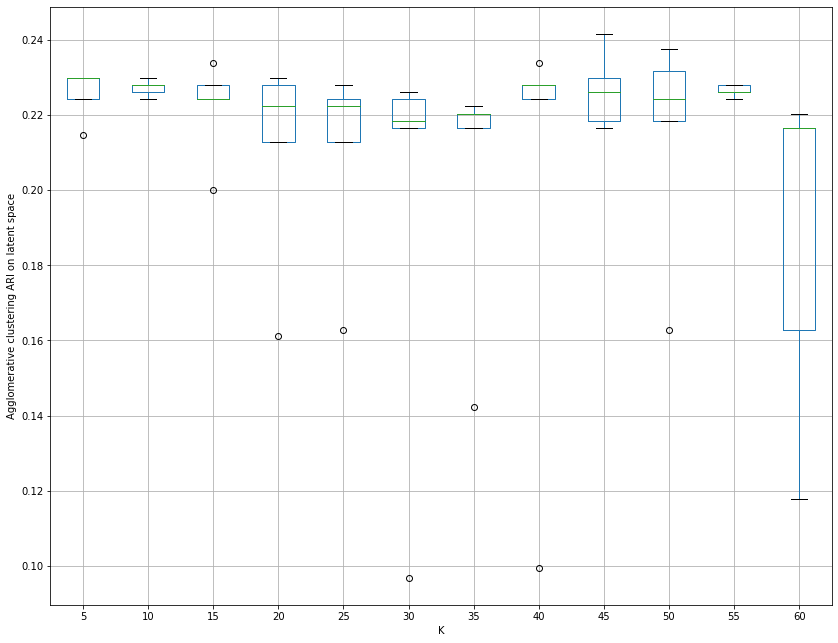

In [ ]:
df = pd.DataFrame(agglo_ARI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering ARI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

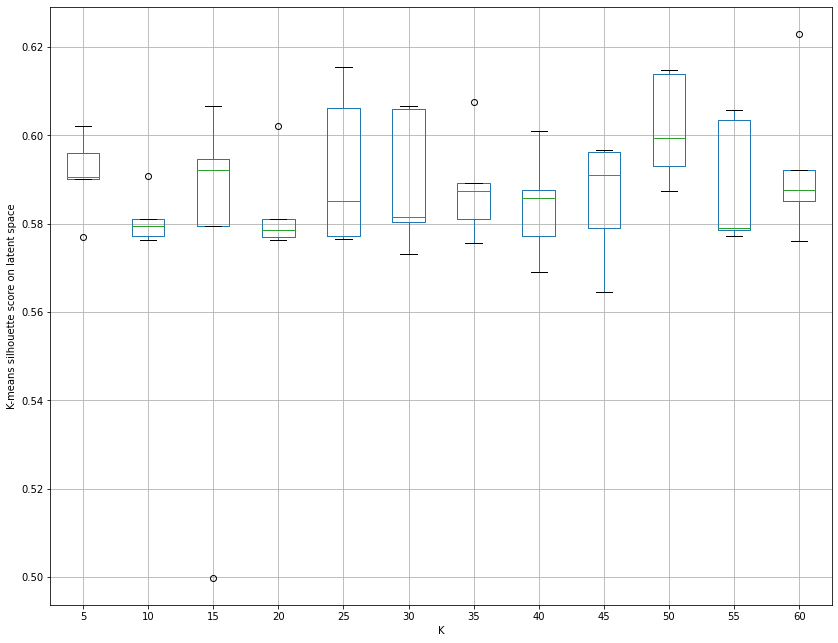

In [ ]:
df = pd.DataFrame(kmeans_silhouette,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means silhouette score on latent space')
boxplot.set_xlabel('K')

# Moons clustering

In [ ]:
kmeans_2_clusters = KMeans(n_clusters=2, n_init=100).fit(moons_datapoints)
retrieved_labels_2_clusters = transform_clusters_to_labels(kmeans_2_clusters.labels_, moons_labels)

print("K_means greedy accuracy score for 2 clusters on initial space:",accuracy_score(moons_labels, retrieved_labels_2_clusters))
print("K_means hungarian accuracy score for 2 clusters on initial space:",cluster_accuracy(moons_labels, kmeans_2_clusters.labels_)[1])
print("K-means normalised mutual info score for 2 clusters on initial space:",normalized_mutual_info_score(moons_labels, kmeans_2_clusters.labels_))
print("K-means ARI for 2 clusters on initial space:",adjusted_rand_score(moons_labels, kmeans_2_clusters.labels_))
print("K-means silhouette score for 2 clusters on initial space:",silhouette_score(moons_datapoints, kmeans_2_clusters.labels_))

K_means greedy accuracy score for 2 clusters on initial space: 0.86
K_means hungarian accuracy score for 2 clusters on initial space: 0.86
K-means normalised mutual info score for 2 clusters on initial space: 0.41582049156429396
K-means ARI for 2 clusters on initial space: 0.5179174657848519
K-means silhouette score for 2 clusters on initial space: 0.5007880991956327


In [ ]:
aggloClustering_2_clusters = AgglomerativeClustering(n_clusters=2).fit(moons_datapoints)
agglo_retrieved_labels = transform_clusters_to_labels(aggloClustering_2_clusters.labels_, moons_labels)

# print the stats on agglomerative clustering

print("Agglomerative clustering on initial space greedy accuracy score:",accuracy_score(moons_labels, agglo_retrieved_labels))
print("Agglomerative clustering on initial space hungarian accuracy score:",cluster_accuracy(moons_labels, aggloClustering_2_clusters.labels_)[1])
print("Normalised mutual info score on agglomerative clustering on initial space:",normalized_mutual_info_score(moons_labels, aggloClustering_2_clusters.labels_))
print("Agglomerative clustering ARI on initial space:",adjusted_rand_score(moons_labels, aggloClustering_2_clusters.labels_))
print("Agglomerative clustering silhouette score for 10 clusters on initial space:",silhouette_score(moons_datapoints, aggloClustering_2_clusters.labels_))

Agglomerative clustering on initial space greedy accuracy score: 0.819
Agglomerative clustering on initial space hungarian accuracy score: 0.819
Normalised mutual info score on agglomerative clustering on initial space: 0.4530314470956316
Agglomerative clustering ARI on initial space: 0.4065277825383417
Agglomerative clustering silhouette score for 10 clusters on initial space: 0.4212145986314873


In [ ]:
data_TSNE = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=400, learning_rate='auto').fit_transform(moons_datapoints)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.025376


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.332253
[t-SNE] KL divergence after 400 iterations: 0.371608


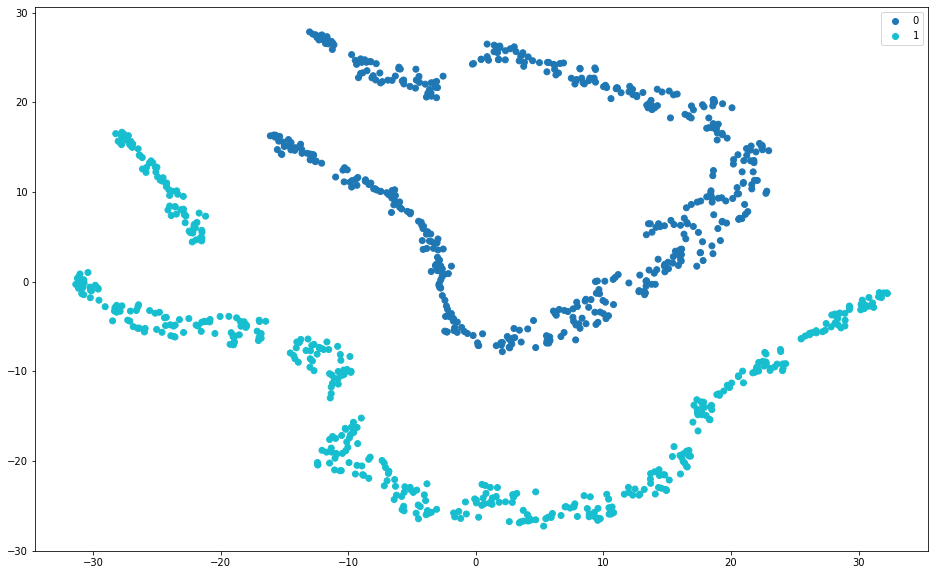

In [ ]:
dataset_labels = [0,1]

plt.figure(figsize=(16,10))
scatterplot = plt.scatter(
    x=data_TSNE[:,0], y=data_TSNE[:,1],
    c=moons_labels,
    cmap="tab10"
)

handles, _ = scatterplot.legend_elements(prop='colors')
plt.legend(handles, dataset_labels)

In [ ]:
def run_experiment(K, dataloader, data_shape, datapoints, labels, epochs, hl1_neurons, hl2_neurons, latent_dimension):

  print('Experiment results for k-means with k =', K, 'clusters:\n')
  print('Running k-means algorithm in order to get our pseudolabels: \n')

  kmeans_initial = KMeans(n_clusters=K, n_init=100).fit(datapoints) 
  cluster_centers = kmeans_initial.cluster_centers_
  cluster_labels = kmeans_initial.labels_
  real_labels = transform_clusters_to_labels(cluster_labels, labels)

  # check TSNE representation of our features according to the k categories

  # print("Creating TSNE representation of our features according to the k categories...\n")

  # pseudolabels_indices = [i for i in range(K)]

  # plt.figure(figsize=(16,10)) 
  # kmeans_scatterplot = plt.scatter(
  #     x=data_TSNE[:,0], y=data_TSNE[:,1],
  #     c=cluster_labels,
  #     cmap="gist_rainbow"
  # )

  # handles = kmeans_scatterplot.legend_elements(num=pseudolabels_indices)[0]
  # plt.legend(handles, pseudolabels_indices)

  # savestring = 'pseudolabels_TSNE_initial_space_k=' + str(K) + '.png'
  # plt.savefig(savestring)

  # find out accuracy of the algorithm in the initial space

  kmeans_initial_hungarian_acc = cluster_accuracy(labels, cluster_labels)[1]
  kmeans_initial_NMI = normalized_mutual_info_score(labels, cluster_labels)
  kmeans_initial_ARI = adjusted_rand_score(labels, cluster_labels)

  print("K_means greedy accuracy score (initial space):",accuracy_score(labels, real_labels))
  print("K_means hungarian accuracy score (initial space):",kmeans_initial_hungarian_acc)
  print("Normalised mutual info score (initial space):",kmeans_initial_NMI)
  print("ARI (initial space):",kmeans_initial_ARI, "\n")

  # using the autoencoder model on our data

  print('Using the autoencoder model on our data: \n')

  kmeans_accuracy_scores = []
  k_means_silhouette_scores = []
  k_means_cluster_error_scores = []
  kmeans_NMI_scores = []
  kmeans_ARI_scores = []
  agglo_accuracy_scores = []
  agglo_NMI_scores = []
  agglo_ARI_scores = []
  
  for i in range(5):

    print("ROUND NUMBER ",i + 1,":\n")
    autoencoder = Autoencoder(input_dimension=data_shape, hl1_neurons=hl1_neurons, hl2_neurons=hl2_neurons, latent_dimension=latent_dimension).to(device)
    autoencoder, loss_list = train_autoencoder(device, dataloader, autoencoder, epochs=epochs)
    latent_data = autoencoder.encoder(datapoints, device)
    
    print("Creating a k-means model on latent data:\n")

    # Maybe we need Standar Scaler

    # std_scaler = StandardScaler()
    # latent_data = std_scaler.fit_transform(latent_data)

    # Clustering on transformed space

    new_kmeans = KMeans(n_clusters=2, n_init=100).fit(latent_data)

    kmeans_clusters = new_kmeans.labels_
    kmeans_cluster_error = new_kmeans.inertia_
    k_means_cluster_error_scores.append(kmeans_cluster_error)
    kmeans_greedy_labels = transform_clusters_to_labels(kmeans_clusters, labels)

    # print the stats on the transformed space
    kmeans_greedy_acc = accuracy_score(labels, kmeans_greedy_labels)

    # These metrics as input they use the output of the clustering algorithm
    kmeans_hungarian_acc = cluster_accuracy(labels, kmeans_clusters)[1]
    kmeans_NMI = normalized_mutual_info_score(labels, kmeans_clusters)
    kmeans_ARI = adjusted_rand_score(labels, kmeans_clusters)

    kmeans_accuracy_scores.append(kmeans_hungarian_acc)
    kmeans_NMI_scores.append(kmeans_NMI)
    kmeans_ARI_scores.append(kmeans_ARI)

    k_means_silhouette_score = silhouette_score(latent_data, kmeans_clusters)
    k_means_silhouette_scores.append(k_means_silhouette_score)

    print("K-means with 10 clusters on latent space stats: \n")
    print("K-means on latent space greedy accuracy score:",kmeans_greedy_acc)
    print("K-means on latent space hungarian accuracy score:",kmeans_hungarian_acc)
    print("Normalised mutual info score on k-means on latent space:", kmeans_NMI)
    print("ARI score on k-means on latent space:", kmeans_ARI)
    print("K-means cluster error on latent space:", kmeans_cluster_error)
    print("K-means silhouette score on latent space:", k_means_silhouette_score, "\n")

    # do agglomerative clustering on the transformed space

    print("Doing agglomerative clustering on MLP output vectors:\n")
    aggloClustering = AgglomerativeClustering(n_clusters=2).fit(latent_data)
    aggloClustering_clusters = aggloClustering.labels_
    agglo_greedy_labels = transform_clusters_to_labels(aggloClustering_clusters, labels)

    # print the stats on agglomerative clustering
    agglo_greedy_acc = accuracy_score(labels, agglo_greedy_labels)
    agglo_hungarian_acc = cluster_accuracy(labels, aggloClustering_clusters)[1]
    agglo_NMI = normalized_mutual_info_score(labels, aggloClustering_clusters)
    agglo_ARI = adjusted_rand_score(labels, aggloClustering_clusters)

    agglo_accuracy_scores.append(agglo_greedy_acc)
    agglo_NMI_scores.append(agglo_NMI)
    agglo_ARI_scores.append(agglo_ARI)

    print("Agglomerative clustering on latent space greedy accuracy score:", agglo_greedy_acc)
    print("Agglomerative clustering on latent space hungarian accuracy score:", agglo_hungarian_acc)
    print("Normalised mutual info score on agglomerative clustering on latent space:",agglo_NMI, "\n")
    print("ARI score on agglomerative clustering on latent space:", agglo_ARI, "\n")

  print("Average k-means accuracy score at latent space:", sum(kmeans_accuracy_scores) / len(kmeans_accuracy_scores), "\n")
  print("Average k-means NMI score at latent space:", sum(kmeans_NMI_scores) / len(kmeans_NMI_scores), "\n")
  print("Average k-means ARI score at latent space:", sum(kmeans_ARI_scores) / len(kmeans_ARI_scores), "\n")
  print("Average agglomerative clustering accuracy score at latent space:", sum(agglo_accuracy_scores) / len(agglo_accuracy_scores), "\n")
  print("Average agglomerative clustering NMI score at latent space:", sum(agglo_NMI_scores) / len(agglo_NMI_scores), "\n")
  print("Average agglomerative clustering ARI score at latent space:", sum(agglo_ARI_scores) / len(agglo_ARI_scores), "\n")
  print("Average k-means silhouette score on latent space:", sum(k_means_silhouette_scores) / len(k_means_silhouette_scores), "\n")
  print("Average k-means cluster error on latent space:", sum(k_means_cluster_error_scores) / len(k_means_cluster_error_scores), "\n")

  return [ kmeans_accuracy_scores, kmeans_NMI_scores, kmeans_ARI_scores, agglo_accuracy_scores, agglo_NMI_scores, agglo_ARI_scores, k_means_silhouette_scores]

In [ ]:
results_for_k_5 = run_experiment(5, moons_dataloader, moons_data_shape, moons_datapoints, moons_labels, 50, hl1_neurons=400, hl2_neurons=200, latent_dimension=1)

Experiment results for k-means with k = 5 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.886
K_means hungarian accuracy score (initial space): 0.886
Normalised mutual info score (initial space): 0.5859996599226486
ARI (initial space): 0.5956002387947761 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.038115
Epoch: 2/50, Loss: 0.024290
Epoch: 3/50, Loss: 0.023511
Epoch: 4/50, Loss: 0.023140
Epoch: 5/50, Loss: 0.023071
Epoch: 6/50, Loss: 0.023008
Epoch: 7/50, Loss: 0.022927
Epoch: 8/50, Loss: 0.023004
Epoch: 9/50, Loss: 0.022813
Epoch: 10/50, Loss: 0.022814
Epoch: 11/50, Loss: 0.022788
Epoch: 12/50, Loss: 0.022696
Epoch: 13/50, Loss: 0.022692
Epoch: 14/50, Loss: 0.022579
Epoch: 15/50, Loss: 0.022445
Epoch: 16/50, Loss: 0.022109
Epoch: 17/50, Loss: 0.022199
Epoch: 18/50, Loss: 0.022216
Epoch: 19/50, Loss: 0.021980
Epoch: 20/50, Loss: 0.021145
Epoch: 21/50, Loss: 0.020403
Epoch: 

In [ ]:
results_for_k_10 = run_experiment(10, moons_dataloader, moons_data_shape, moons_datapoints, moons_labels, 50, hl1_neurons=400, hl2_neurons=200, latent_dimension=1)

Experiment results for k-means with k = 10 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.999
K_means hungarian accuracy score (initial space): 0.999
Normalised mutual info score (initial space): 0.9895915066199539
ARI (initial space): 0.995999996008016 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.041822
Epoch: 2/50, Loss: 0.025675
Epoch: 3/50, Loss: 0.023679
Epoch: 4/50, Loss: 0.023156
Epoch: 5/50, Loss: 0.023125
Epoch: 6/50, Loss: 0.022939
Epoch: 7/50, Loss: 0.022847
Epoch: 8/50, Loss: 0.022785
Epoch: 9/50, Loss: 0.022738
Epoch: 10/50, Loss: 0.022701
Epoch: 11/50, Loss: 0.022659
Epoch: 12/50, Loss: 0.022625
Epoch: 13/50, Loss: 0.022503
Epoch: 14/50, Loss: 0.022352
Epoch: 15/50, Loss: 0.021901
Epoch: 16/50, Loss: 0.022040
Epoch: 17/50, Loss: 0.022063
Epoch: 18/50, Loss: 0.021683
Epoch: 19/50, Loss: 0.021497
Epoch: 20/50, Loss: 0.021206
Epoch: 21/50, Loss: 0.021170
Epoch: 

In [ ]:
results_for_k_15 = run_experiment(15, moons_dataloader, moons_data_shape, moons_datapoints, moons_labels, 50, hl1_neurons=400, hl2_neurons=200, latent_dimension=1)

Experiment results for k-means with k = 15 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.034519
Epoch: 2/50, Loss: 0.023525
Epoch: 3/50, Loss: 0.023370
Epoch: 4/50, Loss: 0.022907
Epoch: 5/50, Loss: 0.022808
Epoch: 6/50, Loss: 0.022626
Epoch: 7/50, Loss: 0.021753
Epoch: 8/50, Loss: 0.019937
Epoch: 9/50, Loss: 0.016074
Epoch: 10/50, Loss: 0.014314
Epoch: 11/50, Loss: 0.012187
Epoch: 12/50, Loss: 0.012017
Epoch: 13/50, Loss: 0.011353
Epoch: 14/50, Loss: 0.011280
Epoch: 15/50, Loss: 0.011900
Epoch: 16/50, Loss: 0.011666
Epoch: 17/50, Loss: 0.011031
Epoch: 18/50, Loss: 0.010207
Epoch: 19/50, Loss: 0.010022
Epoch: 20/50, Loss: 0.010031
Epoch: 21/50, Loss: 0.009883
Epoch: 22/50, Loss: 0.010085
Epoch: 23/5

In [ ]:
results_for_k_20 = run_experiment(20, moons_dataloader, moons_data_shape, moons_datapoints, moons_labels, 50, hl1_neurons=400, hl2_neurons=200, latent_dimension=1)

Experiment results for k-means with k = 20 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.038772
Epoch: 2/50, Loss: 0.025298
Epoch: 3/50, Loss: 0.023954
Epoch: 4/50, Loss: 0.023562
Epoch: 5/50, Loss: 0.023021
Epoch: 6/50, Loss: 0.022768
Epoch: 7/50, Loss: 0.022303
Epoch: 8/50, Loss: 0.021458
Epoch: 9/50, Loss: 0.019876
Epoch: 10/50, Loss: 0.016100
Epoch: 11/50, Loss: 0.013801
Epoch: 12/50, Loss: 0.012395
Epoch: 13/50, Loss: 0.010903
Epoch: 14/50, Loss: 0.010907
Epoch: 15/50, Loss: 0.010881
Epoch: 16/50, Loss: 0.011196
Epoch: 17/50, Loss: 0.011009
Epoch: 18/50, Loss: 0.010913
Epoch: 19/50, Loss: 0.010913
Epoch: 20/50, Loss: 0.010794
Epoch: 21/50, Loss: 0.010913
Epoch: 22/50, Loss: 0.010708
Epoch: 23/5

In [ ]:
results_for_k_25 = run_experiment(25, moons_dataloader, moons_data_shape, moons_datapoints, moons_labels, 50, hl1_neurons=400, hl2_neurons=200, latent_dimension=1)

Experiment results for k-means with k = 25 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.031032
Epoch: 2/50, Loss: 0.023801
Epoch: 3/50, Loss: 0.023443
Epoch: 4/50, Loss: 0.023208
Epoch: 5/50, Loss: 0.023137
Epoch: 6/50, Loss: 0.023027
Epoch: 7/50, Loss: 0.022914
Epoch: 8/50, Loss: 0.023049
Epoch: 9/50, Loss: 0.023042
Epoch: 10/50, Loss: 0.022947
Epoch: 11/50, Loss: 0.022717
Epoch: 12/50, Loss: 0.022910
Epoch: 13/50, Loss: 0.022575
Epoch: 14/50, Loss: 0.022215
Epoch: 15/50, Loss: 0.022168
Epoch: 16/50, Loss: 0.020955
Epoch: 17/50, Loss: 0.020223
Epoch: 18/50, Loss: 0.018584
Epoch: 19/50, Loss: 0.017629
Epoch: 20/50, Loss: 0.016198
Epoch: 21/50, Loss: 0.016091
Epoch: 22/50, Loss: 0.013954
Epoch: 23/5

In [ ]:
results_for_k_30 = run_experiment(30, moons_dataloader, moons_data_shape, moons_datapoints, moons_labels, 50, hl1_neurons=400, hl2_neurons=200, latent_dimension=1)

Experiment results for k-means with k = 30 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.073263
Epoch: 2/50, Loss: 0.038931
Epoch: 3/50, Loss: 0.024169
Epoch: 4/50, Loss: 0.023718
Epoch: 5/50, Loss: 0.023021
Epoch: 6/50, Loss: 0.022586
Epoch: 7/50, Loss: 0.022447
Epoch: 8/50, Loss: 0.021923
Epoch: 9/50, Loss: 0.021385
Epoch: 10/50, Loss: 0.019024
Epoch: 11/50, Loss: 0.017096
Epoch: 12/50, Loss: 0.015026
Epoch: 13/50, Loss: 0.013651
Epoch: 14/50, Loss: 0.013631
Epoch: 15/50, Loss: 0.012280
Epoch: 16/50, Loss: 0.011711
Epoch: 17/50, Loss: 0.011043
Epoch: 18/50, Loss: 0.010133
Epoch: 19/50, Loss: 0.009960
Epoch: 20/50, Loss: 0.010211
Epoch: 21/50, Loss: 0.010479
Epoch: 22/50, Loss: 0.010439
Epoch: 23/5

In [ ]:
results_for_k_35 = run_experiment(35, moons_dataloader, moons_data_shape, moons_datapoints, moons_labels, 50, hl1_neurons=400, hl2_neurons=200, latent_dimension=1)

Experiment results for k-means with k = 35 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.027359
Epoch: 2/50, Loss: 0.023635
Epoch: 3/50, Loss: 0.023375
Epoch: 4/50, Loss: 0.023096
Epoch: 5/50, Loss: 0.023014
Epoch: 6/50, Loss: 0.022842
Epoch: 7/50, Loss: 0.022740
Epoch: 8/50, Loss: 0.022590
Epoch: 9/50, Loss: 0.022191
Epoch: 10/50, Loss: 0.021287
Epoch: 11/50, Loss: 0.019218
Epoch: 12/50, Loss: 0.016832
Epoch: 13/50, Loss: 0.014389
Epoch: 14/50, Loss: 0.014578
Epoch: 15/50, Loss: 0.013165
Epoch: 16/50, Loss: 0.011920
Epoch: 17/50, Loss: 0.011719
Epoch: 18/50, Loss: 0.011779
Epoch: 19/50, Loss: 0.011534
Epoch: 20/50, Loss: 0.011204
Epoch: 21/50, Loss: 0.011351
Epoch: 22/50, Loss: 0.011473
Epoch: 23/5

In [ ]:
results_for_k_40 = run_experiment(40, moons_dataloader, moons_data_shape, moons_datapoints, moons_labels, 50, hl1_neurons=400, hl2_neurons=200, latent_dimension=1)

Experiment results for k-means with k = 40 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.058252
Epoch: 2/50, Loss: 0.029905
Epoch: 3/50, Loss: 0.023118
Epoch: 4/50, Loss: 0.022862
Epoch: 5/50, Loss: 0.022475
Epoch: 6/50, Loss: 0.021358
Epoch: 7/50, Loss: 0.019128
Epoch: 8/50, Loss: 0.016609
Epoch: 9/50, Loss: 0.014394
Epoch: 10/50, Loss: 0.014171
Epoch: 11/50, Loss: 0.015798
Epoch: 12/50, Loss: 0.012968
Epoch: 13/50, Loss: 0.011960
Epoch: 14/50, Loss: 0.011478
Epoch: 15/50, Loss: 0.010974
Epoch: 16/50, Loss: 0.010374
Epoch: 17/50, Loss: 0.010169
Epoch: 18/50, Loss: 0.009953
Epoch: 19/50, Loss: 0.010225
Epoch: 20/50, Loss: 0.010947
Epoch: 21/50, Loss: 0.010683
Epoch: 22/50, Loss: 0.010635
Epoch: 23/5

In [ ]:
results_for_k_45 = run_experiment(45, moons_dataloader, moons_data_shape, moons_datapoints, moons_labels, 50, hl1_neurons=400, hl2_neurons=200, latent_dimension=1)

Experiment results for k-means with k = 45 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.072436
Epoch: 2/50, Loss: 0.057122
Epoch: 3/50, Loss: 0.053399
Epoch: 4/50, Loss: 0.040028
Epoch: 5/50, Loss: 0.026428
Epoch: 6/50, Loss: 0.025091
Epoch: 7/50, Loss: 0.024029
Epoch: 8/50, Loss: 0.023398
Epoch: 9/50, Loss: 0.023159
Epoch: 10/50, Loss: 0.022757
Epoch: 11/50, Loss: 0.022328
Epoch: 12/50, Loss: 0.021941
Epoch: 13/50, Loss: 0.021701
Epoch: 14/50, Loss: 0.020906
Epoch: 15/50, Loss: 0.021126
Epoch: 16/50, Loss: 0.020521
Epoch: 17/50, Loss: 0.020238
Epoch: 18/50, Loss: 0.019889
Epoch: 19/50, Loss: 0.019307
Epoch: 20/50, Loss: 0.018853
Epoch: 21/50, Loss: 0.018808
Epoch: 22/50, Loss: 0.019293
Epoch: 23/5

In [ ]:
results_for_k_50 = run_experiment(50, moons_dataloader, moons_data_shape, moons_datapoints, moons_labels, 50, hl1_neurons=400, hl2_neurons=200, latent_dimension=1)

Experiment results for k-means with k = 50 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.039239
Epoch: 2/50, Loss: 0.024852
Epoch: 3/50, Loss: 0.023703
Epoch: 4/50, Loss: 0.023298
Epoch: 5/50, Loss: 0.022846
Epoch: 6/50, Loss: 0.022418
Epoch: 7/50, Loss: 0.021958
Epoch: 8/50, Loss: 0.020599
Epoch: 9/50, Loss: 0.018517
Epoch: 10/50, Loss: 0.014738
Epoch: 11/50, Loss: 0.013469
Epoch: 12/50, Loss: 0.012415
Epoch: 13/50, Loss: 0.012788
Epoch: 14/50, Loss: 0.012150
Epoch: 15/50, Loss: 0.011242
Epoch: 16/50, Loss: 0.011666
Epoch: 17/50, Loss: 0.011735
Epoch: 18/50, Loss: 0.011854
Epoch: 19/50, Loss: 0.011150
Epoch: 20/50, Loss: 0.011303
Epoch: 21/50, Loss: 0.011343
Epoch: 22/50, Loss: 0.010434
Epoch: 23/5

In [ ]:
results_for_k_55 = run_experiment(55, moons_dataloader, moons_data_shape, moons_datapoints, moons_labels, 50, hl1_neurons=400, hl2_neurons=200, latent_dimension=1)

Experiment results for k-means with k = 55 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.036641
Epoch: 2/50, Loss: 0.024397
Epoch: 3/50, Loss: 0.023626
Epoch: 4/50, Loss: 0.023168
Epoch: 5/50, Loss: 0.022983
Epoch: 6/50, Loss: 0.022890
Epoch: 7/50, Loss: 0.022640
Epoch: 8/50, Loss: 0.021808
Epoch: 9/50, Loss: 0.019973
Epoch: 10/50, Loss: 0.016095
Epoch: 11/50, Loss: 0.015177
Epoch: 12/50, Loss: 0.013097
Epoch: 13/50, Loss: 0.012908
Epoch: 14/50, Loss: 0.013450
Epoch: 15/50, Loss: 0.013749
Epoch: 16/50, Loss: 0.012212
Epoch: 17/50, Loss: 0.010910
Epoch: 18/50, Loss: 0.011157
Epoch: 19/50, Loss: 0.011054
Epoch: 20/50, Loss: 0.011053
Epoch: 21/50, Loss: 0.011019
Epoch: 22/50, Loss: 0.010737
Epoch: 23/5

In [ ]:
results_for_k_60 = run_experiment(60, moons_dataloader, moons_data_shape, moons_datapoints, moons_labels, 50, hl1_neurons=400, hl2_neurons=200, latent_dimension=1)

Experiment results for k-means with k = 60 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 1.0
K_means hungarian accuracy score (initial space): 1.0
Normalised mutual info score (initial space): 1.0
ARI (initial space): 1.0 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.029107
Epoch: 2/50, Loss: 0.023988
Epoch: 3/50, Loss: 0.023271
Epoch: 4/50, Loss: 0.023293
Epoch: 5/50, Loss: 0.022962
Epoch: 6/50, Loss: 0.022993
Epoch: 7/50, Loss: 0.022622
Epoch: 8/50, Loss: 0.022500
Epoch: 9/50, Loss: 0.021826
Epoch: 10/50, Loss: 0.021177
Epoch: 11/50, Loss: 0.018001
Epoch: 12/50, Loss: 0.016102
Epoch: 13/50, Loss: 0.013981
Epoch: 14/50, Loss: 0.011893
Epoch: 15/50, Loss: 0.012305
Epoch: 16/50, Loss: 0.011804
Epoch: 17/50, Loss: 0.010859
Epoch: 18/50, Loss: 0.010329
Epoch: 19/50, Loss: 0.010485
Epoch: 20/50, Loss: 0.010389
Epoch: 21/50, Loss: 0.010257
Epoch: 22/50, Loss: 0.010613
Epoch: 23/5

In [ ]:
kmeans_acc = np.zeros((5,12))
kmeans_NMI = np.zeros((5,12))
kmeans_ARI = np.zeros((5,12))
agglo_acc = np.zeros((5,12))
agglo_NMI = np.zeros((5,12))
agglo_ARI = np.zeros((5,12))
kmeans_silhouette = np.zeros((5,12))

for i in range(5):
  
  kmeans_acc[i][0] = results_for_k_5[0][i]
  kmeans_acc[i][1] = results_for_k_10[0][i]
  kmeans_acc[i][2] = results_for_k_15[0][i]
  kmeans_acc[i][3] = results_for_k_20[0][i]
  kmeans_acc[i][4] = results_for_k_25[0][i]
  kmeans_acc[i][5] = results_for_k_30[0][i]
  kmeans_acc[i][6] = results_for_k_35[0][i]
  kmeans_acc[i][7] = results_for_k_40[0][i]
  kmeans_acc[i][8] = results_for_k_45[0][i]
  kmeans_acc[i][9] = results_for_k_50[0][i]
  kmeans_acc[i][10] = results_for_k_55[0][i]
  kmeans_acc[i][11] = results_for_k_60[0][i]

  kmeans_NMI[i][0] = results_for_k_5[1][i]
  kmeans_NMI[i][1] = results_for_k_10[1][i]
  kmeans_NMI[i][2] = results_for_k_15[1][i]
  kmeans_NMI[i][3] = results_for_k_20[1][i]
  kmeans_NMI[i][4] = results_for_k_25[1][i]
  kmeans_NMI[i][5] = results_for_k_30[1][i]
  kmeans_NMI[i][6] = results_for_k_35[1][i]
  kmeans_NMI[i][7] = results_for_k_40[1][i]
  kmeans_NMI[i][8] = results_for_k_45[1][i]
  kmeans_NMI[i][9] = results_for_k_50[1][i]
  kmeans_NMI[i][10] = results_for_k_55[1][i]
  kmeans_NMI[i][11] = results_for_k_60[1][i]

  kmeans_ARI[i][0] = results_for_k_5[2][i]
  kmeans_ARI[i][1] = results_for_k_10[2][i]
  kmeans_ARI[i][2] = results_for_k_15[2][i]
  kmeans_ARI[i][3] = results_for_k_20[2][i]
  kmeans_ARI[i][4] = results_for_k_25[2][i]
  kmeans_ARI[i][5] = results_for_k_30[2][i]
  kmeans_ARI[i][6] = results_for_k_35[2][i]
  kmeans_ARI[i][7] = results_for_k_40[2][i]
  kmeans_ARI[i][8] = results_for_k_45[2][i]
  kmeans_ARI[i][9] = results_for_k_50[2][i]
  kmeans_ARI[i][10] = results_for_k_55[2][i]
  kmeans_ARI[i][11] = results_for_k_60[2][i]

  agglo_acc[i][0] = results_for_k_5[3][i]
  agglo_acc[i][1] = results_for_k_10[3][i]
  agglo_acc[i][2] = results_for_k_15[3][i]
  agglo_acc[i][3] = results_for_k_20[3][i]
  agglo_acc[i][4] = results_for_k_25[3][i]
  agglo_acc[i][5] = results_for_k_30[3][i]
  agglo_acc[i][6] = results_for_k_35[3][i]
  agglo_acc[i][7] = results_for_k_40[3][i]
  agglo_acc[i][8] = results_for_k_45[3][i]
  agglo_acc[i][9] = results_for_k_50[3][i]
  agglo_acc[i][10] = results_for_k_55[3][i]
  agglo_acc[i][11] = results_for_k_60[3][i]

  agglo_NMI[i][0] = results_for_k_5[4][i]
  agglo_NMI[i][1] = results_for_k_10[4][i]
  agglo_NMI[i][2] = results_for_k_15[4][i]
  agglo_NMI[i][3] = results_for_k_20[4][i]
  agglo_NMI[i][4] = results_for_k_25[4][i]
  agglo_NMI[i][5] = results_for_k_30[4][i]
  agglo_NMI[i][6] = results_for_k_35[4][i]
  agglo_NMI[i][7] = results_for_k_40[4][i]
  agglo_NMI[i][8] = results_for_k_45[4][i]
  agglo_NMI[i][9] = results_for_k_50[4][i]
  agglo_NMI[i][10] = results_for_k_55[4][i]
  agglo_NMI[i][11] = results_for_k_60[4][i]

  agglo_ARI[i][0] = results_for_k_5[5][i]
  agglo_ARI[i][1] = results_for_k_10[5][i]
  agglo_ARI[i][2] = results_for_k_15[5][i]
  agglo_ARI[i][3] = results_for_k_20[5][i]
  agglo_ARI[i][4] = results_for_k_25[5][i]
  agglo_ARI[i][5] = results_for_k_30[5][i]
  agglo_ARI[i][6] = results_for_k_35[5][i]
  agglo_ARI[i][7] = results_for_k_40[5][i]
  agglo_ARI[i][8] = results_for_k_45[5][i]
  agglo_ARI[i][9] = results_for_k_50[5][i]
  agglo_ARI[i][10] = results_for_k_55[5][i]
  agglo_ARI[i][11] = results_for_k_60[5][i]

  kmeans_silhouette[i][0] = results_for_k_5[6][i]
  kmeans_silhouette[i][1] = results_for_k_10[6][i]
  kmeans_silhouette[i][2] = results_for_k_15[6][i]
  kmeans_silhouette[i][3] = results_for_k_20[6][i]
  kmeans_silhouette[i][4] = results_for_k_25[6][i]
  kmeans_silhouette[i][5] = results_for_k_30[6][i]
  kmeans_silhouette[i][6] = results_for_k_35[6][i]
  kmeans_silhouette[i][7] = results_for_k_40[6][i]
  kmeans_silhouette[i][8] = results_for_k_45[6][i]
  kmeans_silhouette[i][9] = results_for_k_50[6][i]
  kmeans_silhouette[i][10] = results_for_k_55[6][i]
  kmeans_silhouette[i][11] = results_for_k_60[6][i]


Text(0.5, 0, 'K')

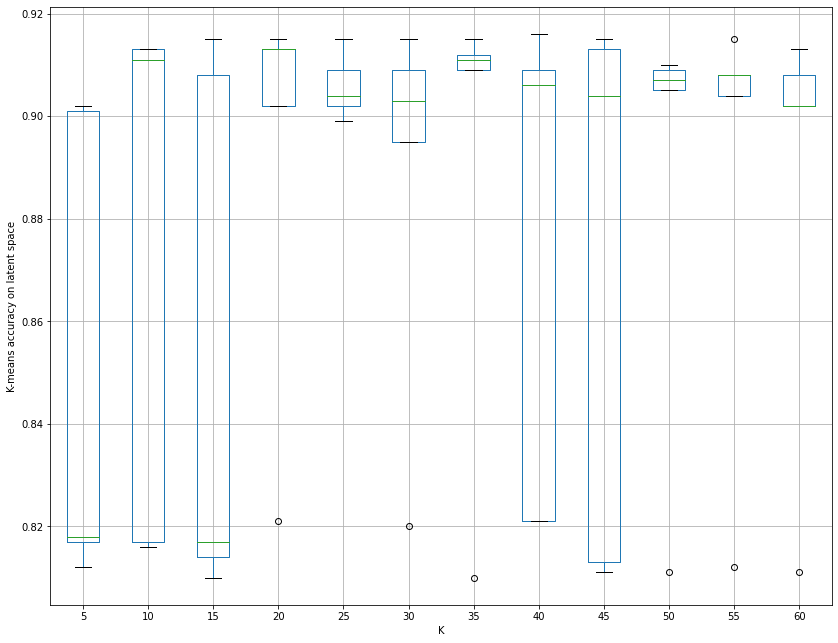

In [ ]:
columns = ['5', '10','15', '20', '25', '30', '35', '40', '45', '50', '55', '60']

df = pd.DataFrame(kmeans_acc,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means accuracy on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

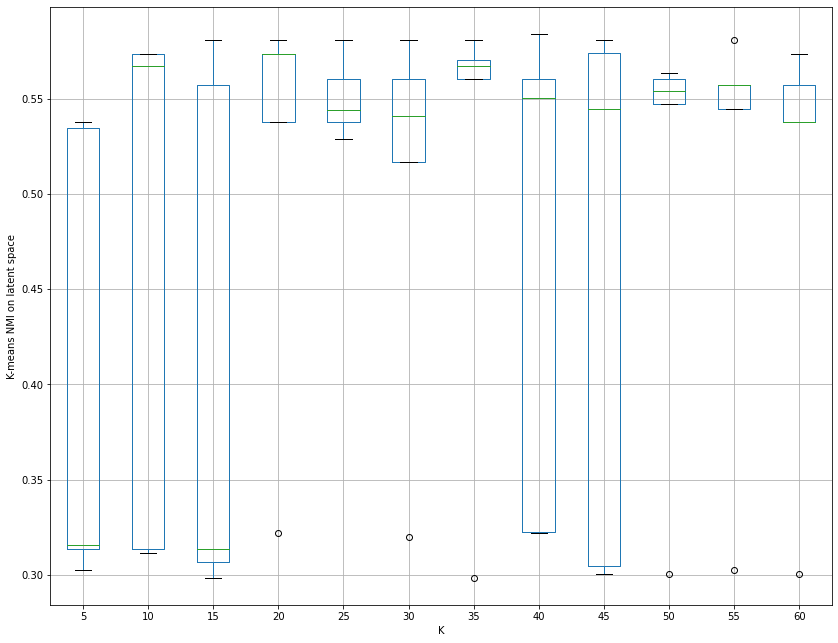

In [ ]:
df = pd.DataFrame(kmeans_NMI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means NMI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

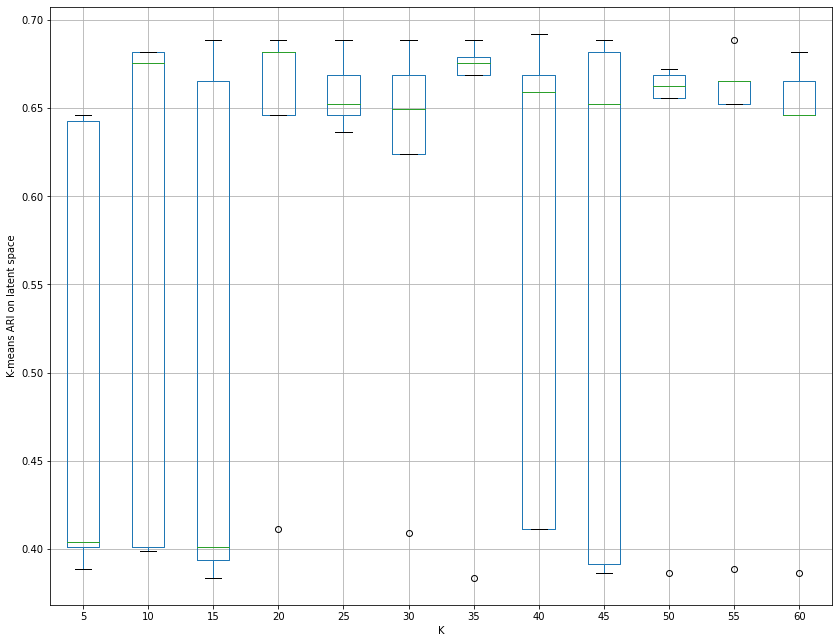

In [ ]:
df = pd.DataFrame(kmeans_ARI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means ARI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

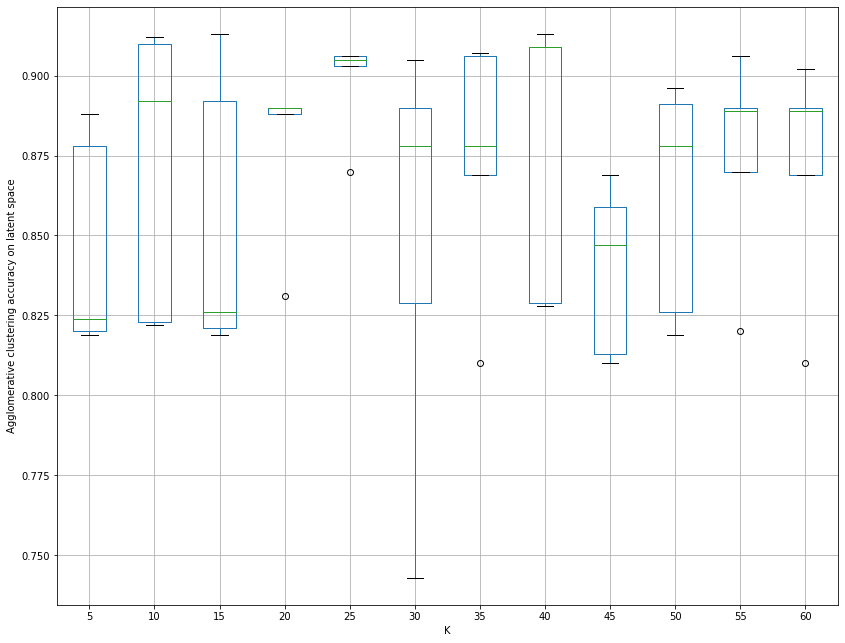

In [ ]:
df = pd.DataFrame(agglo_acc,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering accuracy on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

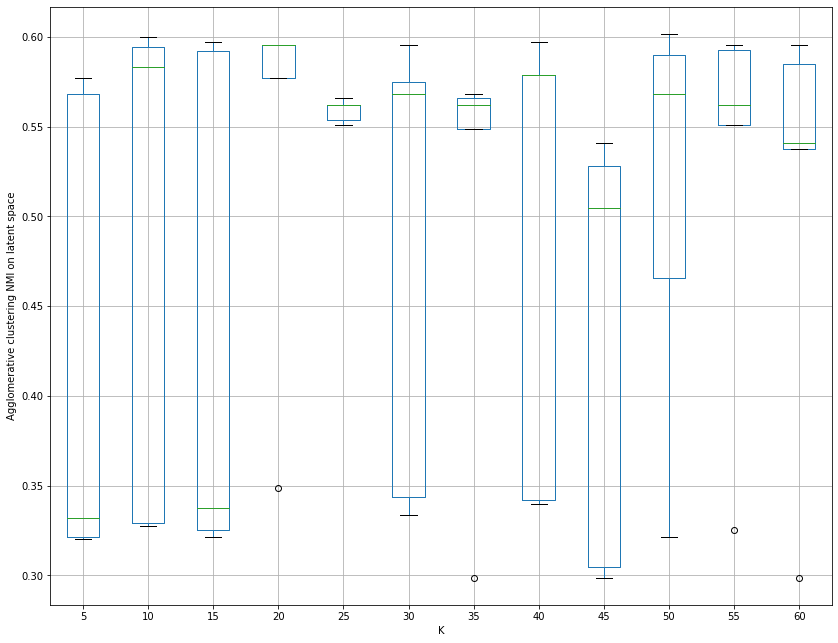

In [ ]:
df = pd.DataFrame(agglo_NMI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering NMI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

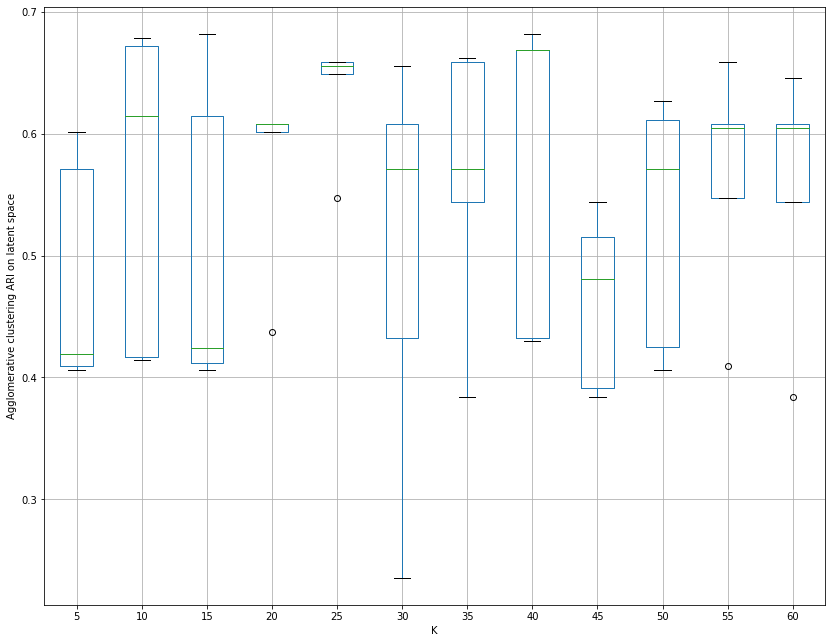

In [ ]:
df = pd.DataFrame(agglo_ARI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering ARI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

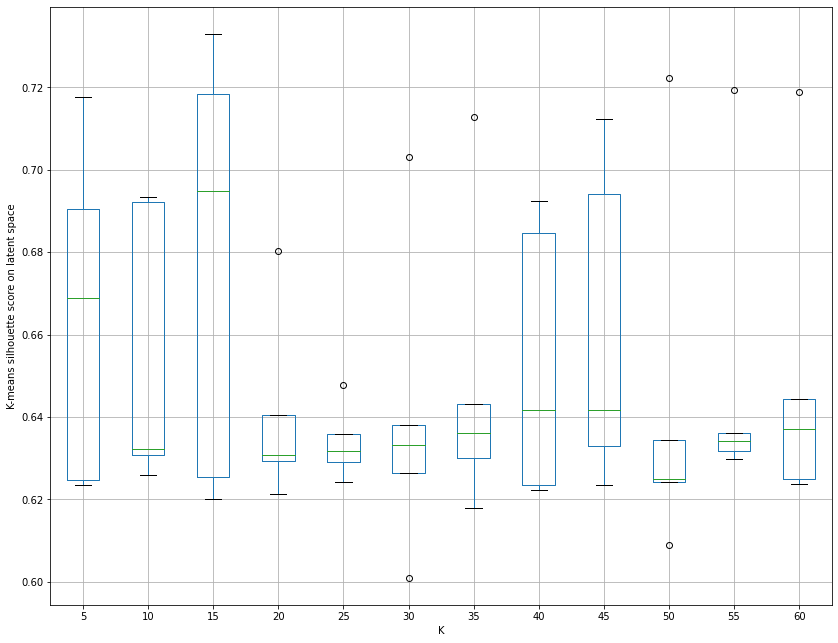

In [ ]:
df = pd.DataFrame(kmeans_silhouette,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means silhouette score on latent space')
boxplot.set_xlabel('K')